# Complete Aethalometer-FTIR/HIPS Data Pipeline

This notebook provides a complete pipeline for loading, processing, and merging:
- **Aethalometer data** (PKL and CSV formats)
- **FTIR/HIPS filter data** (SQLite database)
- **Time-matched merging** with quality assessment
- **Statistical analysis** and visualization

## Pipeline Overview:
1. **Setup and Configuration**
2. **Database Loading** (FTIR/HIPS data)
3. **Aethalometer Loading** (PKL and CSV files)
4. **Quality Assessment** (9am-9am period analysis)
5. **Time-Matched Merging**
6. **Statistical Analysis**
7. **Visualization and Export**

## 1. Setup and Configuration

In [49]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import sys
from pathlib import Path
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Union, Optional, Any, Tuple
import pickle

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add src directory to path for modular system access
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🚀 Aethalometer-FTIR/HIPS Pipeline with Modular System")
print("=" * 60)

🚀 Aethalometer-FTIR/HIPS Pipeline with Modular System


In [50]:
## 2. Configuration Parameters

In [51]:
# =============================================================================
# CONFIGURATION SECTION - UPDATE THESE PATHS FOR YOUR DATA
# =============================================================================

# File paths - UPDATE THESE TO YOUR ACTUAL FILE PATHS
AETHALOMETER_FILES = {
    'pkl_data': "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/df_uncleaned_Jacros_API_and_OG.pkl",
    'csv_data': "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Raw/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
}

FTIR_DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"

# Analysis parameters
SITE_CODE = 'ETAD'
WAVELENGTH = 'Red'  # Options: 'Red', 'Blue', 'Green', 'UV', 'IR'
QUALITY_THRESHOLD = 10  # Maximum missing minutes for "excellent" quality
OUTPUT_DIR = "outputs"
OUTPUT_FORMAT = "jpl"  # 'jpl' or 'standard' format

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📊 Configuration:")
print(f"   Site: {SITE_CODE}")
print(f"   Wavelength: {WAVELENGTH}")
print(f"   Output format: {OUTPUT_FORMAT}")
print(f"   Quality threshold: {QUALITY_THRESHOLD} minutes")


📊 Configuration:
   Site: ETAD
   Wavelength: Red
   Output format: jpl
   Quality threshold: 10 minutes


In [52]:
# =============================================================================
# MODULAR SYSTEM IMPORTS AND SETUP
# =============================================================================

def setup_modular_system():
    """Import and setup the modular aethalometer system"""
    
    print("📦 Setting up modular system...")
    
    # Add the src directory to Python path
    import sys
    import os
    
    # Get the parent directory (aethmodular) and add src to path
    notebook_dir = os.path.dirname(os.path.abspath(''))
    if notebook_dir.endswith('notebooks'):
        project_root = os.path.dirname(notebook_dir)
    else:
        project_root = notebook_dir
    
    src_path = os.path.join(project_root, 'src')
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
    print(f"✅ Added {src_path} to Python path")
    
    # Dictionary to store successfully imported components
    imported_components = {
        'loaders': {},
        'analysis': {},
        'utils': {}
    }
    
    # Try importing aethalometer loaders
    try:
        from data.loaders.aethalometer import (
            AethalometerPKLLoader, 
            AethalometerCSVLoader,
            load_aethalometer_data
        )
        imported_components['loaders'].update({
            'AethalometerPKLLoader': AethalometerPKLLoader,
            'AethalometerCSVLoader': AethalometerCSVLoader,
            'load_aethalometer_data': load_aethalometer_data
        })
        print("✅ Aethalometer loaders imported")
    except ImportError as e:
        print(f"⚠️ Aethalometer loaders failed: {e}")
    
    # Try importing database loader
    try:
        from data.loaders.database import FTIRHIPSLoader
        imported_components['loaders']['FTIRHIPSLoader'] = FTIRHIPSLoader
        print("✅ Database loader imported")
    except ImportError as e:
        print(f"⚠️ Database loader failed: {e}")
    
    # Try importing analysis modules
    try:
        from analysis.bc.black_carbon_analyzer import BlackCarbonAnalyzer
        imported_components['analysis']['BlackCarbonAnalyzer'] = BlackCarbonAnalyzer
        print("✅ Black carbon analyzer imported")
    except ImportError as e:
        print(f"⚠️ Black carbon analyzer failed: {e}")
    
    try:
        from analysis.bc.source_apportionment import SourceApportionmentAnalyzer
        imported_components['analysis']['SourceApportionmentAnalyzer'] = SourceApportionmentAnalyzer
        print("✅ Source apportionment analyzer imported")
    except ImportError as e:
        print(f"⚠️ Source apportionment analyzer failed: {e}")
    
    # Try importing visualization utilities
    try:
        from utils.plotting import AethalometerPlotter
        imported_components['utils']['AethalometerPlotter'] = AethalometerPlotter
        print("✅ Aethalometer plotter imported")
    except ImportError as e:
        print(f"⚠️ Aethalometer plotter failed: {e}")
    
    try:
        from config.plotting import setup_plotting_style
        setup_plotting_style()
        print("✅ Plotting style configured")
    except ImportError as e:
        print(f"⚠️ Plotting style config failed: {e}")
    
    # Try importing utility functions
    try:
        from utils.file_io import ensure_output_directory
        imported_components['utils']['ensure_output_directory'] = ensure_output_directory
        print("✅ File I/O utilities imported")
    except ImportError as e:
        print(f"⚠️ File I/O utilities failed: {e}")
    
    try:
        # Import validation functions from data processors (only existing functions)
        from data.processors.validation import (
            validate_columns_exist, 
            get_valid_data_mask,
            validate_sample_size,
            check_data_range
        )
        imported_components['utils'].update({
            'validate_columns_exist': validate_columns_exist,
            'get_valid_data_mask': get_valid_data_mask,
            'validate_sample_size': validate_sample_size,
            'check_data_range': check_data_range
        })
        print("✅ Data validation functions imported")
    except ImportError as e:
        print(f"⚠️ Data validation failed: {e}")
    
    # Return what we successfully imported
    if any(imported_components.values()):
        success_count = sum(len(v) for v in imported_components.values())
        print(f"✅ Successfully imported {success_count} components")
        return imported_components
    else:
        print("⚠️ No modular components could be imported")
        print(f"📍 Current working directory: {os.getcwd()}")
        print(f"📍 Python path includes: {sys.path[:3]}...")
        return None

# Setup the modular system
modular_components = setup_modular_system()
MODULAR_AVAILABLE = modular_components is not None

if MODULAR_AVAILABLE:
    print(f"\n🎉 Modular system available!")
    print(f"📊 Available components:")
    for category, components in modular_components.items():
        if components:
            print(f"   {category}: {list(components.keys())}")
else:
    print("\n📝 Falling back to basic functionality...")

📦 Setting up modular system...
✅ Added /Users/ahzs645/Github/aethmodular/src to Python path
✅ Aethalometer loaders imported
✅ Database loader imported
✅ Black carbon analyzer imported
✅ Source apportionment analyzer imported
✅ Aethalometer plotter imported
✅ Plotting style configured
✅ File I/O utilities imported
✅ Data validation functions imported
✅ Successfully imported 12 components

🎉 Modular system available!
📊 Available components:
   loaders: ['AethalometerPKLLoader', 'AethalometerCSVLoader', 'load_aethalometer_data', 'FTIRHIPSLoader']
   analysis: ['BlackCarbonAnalyzer', 'SourceApportionmentAnalyzer']
   utils: ['AethalometerPlotter', 'ensure_output_directory', 'validate_columns_exist', 'get_valid_data_mask', 'validate_sample_size', 'check_data_range']


In [53]:
# =============================================================================
# ENHANCED AETHALOMETER LOADING WITH MODULAR SYSTEM
# =============================================================================

def load_aethalometer_with_modular_system(file_path: str, 
                                        output_format: str = "jpl",
                                        site_filter: Optional[str] = None) -> Tuple[Optional[pd.DataFrame], Dict]:
    """
    Load aethalometer data using the modular system
    
    Parameters:
    -----------
    file_path : str
        Path to aethalometer data file (.pkl or .csv)
    output_format : str
        Output format ('jpl' or 'standard')
    site_filter : str, optional
        Filter data by site
        
    Returns:
    --------
    tuple
        (DataFrame, summary_dict)
    """
    
    print(f"📁 Loading with modular system: {Path(file_path).name}")
    print(f"🔧 Output format: {output_format}")
    
    if not MODULAR_AVAILABLE:
        raise ImportError("Modular system not available")
    
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None, {}
    
    try:
        # Use the unified loading function from modular system
        load_function = modular_components['loaders']['load_aethalometer_data']
        
        df = load_function(
            file_path,
            output_format=output_format,
            site_filter=site_filter,
            set_datetime_index=True
        )
        
        if df is None or len(df) == 0:
            print(f"❌ No data loaded from {file_path}")
            return None, {}
        
        # Generate comprehensive summary
        summary = {
            'file_name': Path(file_path).name,
            'file_type': Path(file_path).suffix,
            'format': output_format,
            'shape': df.shape,
            'columns': len(df.columns),
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'bc_columns': [col for col in df.columns if '.BCc' in col or 'BC' in col.upper()],
            'atn_columns': [col for col in df.columns if '.ATN' in col or 'ATN' in col.upper()],
            'time_range': (df.index.min(), df.index.max()) if hasattr(df.index, 'min') else None,
            'missing_data_pct': (df.isnull().sum().sum() / df.size) * 100,
            'has_datetime_index': isinstance(df.index, pd.DatetimeIndex)
        }
        
        print(f"✅ Successfully loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"📊 Format: {output_format}")
        print(f"📊 Memory usage: {summary['memory_mb']:.2f} MB")
        print(f"🧮 BC columns found: {len(summary['bc_columns'])}")
        print(f"📈 ATN columns found: {len(summary['atn_columns'])}")
        
        if summary['time_range']:
            print(f"📅 Time range: {summary['time_range'][0]} to {summary['time_range'][1]}")
        
        return df, summary
        
    except Exception as e:
        print(f"❌ Error loading with modular system: {e}")
        return None, {}

def load_aethalometer_fallback(file_path: str) -> Tuple[Optional[pd.DataFrame], Dict]:
    """
    Fallback direct loading method when modular system fails
    """
    
    print(f"🔄 Using fallback loading for: {Path(file_path).name}")
    
    try:
        file_ext = Path(file_path).suffix.lower()
        
        if file_ext == '.pkl':
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            print(f"✅ Direct PKL load: {df.shape[0]:,} rows × {df.shape[1]} columns")
            
        elif file_ext == '.csv':
            df = pd.read_csv(file_path)
            print(f"✅ Direct CSV load: {df.shape[0]:,} rows × {df.shape[1]} columns")
            
            # Handle datetime conversion for CSV
            if 'Time (UTC)' in df.columns:
                df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
                df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
                df.set_index('Time (Local)', inplace=True)
            elif 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df['datetime'])
                df.set_index('datetime', inplace=True)
        
        else:
            print(f"❌ Unsupported file format: {file_ext}")
            return None, {}
        
        # Ensure datetime index
        if not isinstance(df.index, pd.DatetimeIndex):
            # Try to convert index or find datetime column
            datetime_cols = ['datetime', 'timestamp', 'Time', 'Date']
            for col in datetime_cols:
                if col in df.columns:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    df = df[df[col].notna()]
                    df.set_index(col, inplace=True)
                    break
        
        # Generate basic summary
        summary = {
            'file_name': Path(file_path).name,
            'file_type': Path(file_path).suffix,
            'format': 'fallback',
            'shape': df.shape,
            'bc_columns': [col for col in df.columns if 'BC' in col.upper()],
            'atn_columns': [col for col in df.columns if 'ATN' in col.upper()],
            'time_range': (df.index.min(), df.index.max()) if isinstance(df.index, pd.DatetimeIndex) else None,
            'has_datetime_index': isinstance(df.index, pd.DatetimeIndex)
        }
        
        return df, summary
        
    except Exception as e:
        print(f"❌ Fallback loading failed: {e}")
        return None, {}

def load_aethalometer_robust(file_path: str, 
                           output_format: str = "jpl",
                           site_filter: Optional[str] = None) -> Tuple[Optional[pd.DataFrame], Dict]:
    """
    Robust aethalometer loading with modular system + fallback
    """
    
    # Try modular system first
    if MODULAR_AVAILABLE:
        df, summary = load_aethalometer_with_modular_system(file_path, output_format, site_filter)
        if df is not None:
            return df, summary
        print("⚠️ Modular system failed, trying fallback...")
    
    # Fallback to direct loading
    df, summary = load_aethalometer_fallback(file_path)
    
    if df is not None:
        print("✅ Fallback loading successful")
    else:
        print("❌ All loading methods failed")
    
    return df, summary

In [54]:
# =============================================================================
# ENHANCED FTIR/HIPS LOADING WITH MODULAR SYSTEM
# =============================================================================

def load_ftir_hips_with_modular_system(db_path: str, site_code: str) -> Optional[pd.DataFrame]:
    """Load FTIR/HIPS data using modular system"""
    
    print(f"🗃️ Loading FTIR/HIPS data with modular system...")
    
    if not MODULAR_AVAILABLE:
        print("⚠️ Modular system not available for FTIR loading")
        return None
    
    try:
        FTIRHIPSLoader = modular_components['loaders']['FTIRHIPSLoader']
        
        loader = FTIRHIPSLoader(db_path)
        
        # Get available sites
        available_sites = loader.get_available_sites()
        print(f"📊 Available sites: {available_sites}")
        
        if site_code not in available_sites:
            print(f"⚠️ Site '{site_code}' not found in database")
            return None
        
        # Load data
        df = loader.load(site_code)
        
        if len(df) > 0:
            print(f"✅ Loaded {len(df)} FTIR/HIPS samples")
            print(f"📅 Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
            return df
        else:
            print("❌ No FTIR/HIPS data found")
            return None
            
    except Exception as e:
        print(f"❌ Modular FTIR loading failed: {e}")
        return None

def load_ftir_hips_fallback(db_path: str, site_code: str) -> Optional[pd.DataFrame]:
    """Fallback FTIR/HIPS loading"""
    
    print(f"🔄 Using fallback FTIR loading...")
    
    try:
        conn = sqlite3.connect(db_path)
        
        # Try standard query
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, f.filter_type,
            m.volume_m3, m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m ON f.filter_id = m.filter_id
        WHERE f.site_code = ?
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn, params=(site_code,))
        conn.close()
        
        if len(df) > 0:
            df['sample_date'] = pd.to_datetime(df['sample_date'])
            print(f"✅ Fallback FTIR load: {len(df)} samples")
            return df
        else:
            print("❌ No FTIR data found with fallback method")
            return None
            
    except Exception as e:
        print(f"❌ Fallback FTIR loading failed: {e}")
        return None

def load_ftir_hips_robust(db_path: str, site_code: str) -> Optional[pd.DataFrame]:
    """Robust FTIR/HIPS loading with modular + fallback"""
    
    # Try modular system first
    if MODULAR_AVAILABLE:
        df = load_ftir_hips_with_modular_system(db_path, site_code)
        if df is not None:
            return df
        print("⚠️ Modular FTIR loading failed, trying fallback...")
    
    # Fallback method
    return load_ftir_hips_fallback(db_path, site_code)

In [55]:
def load_aethalometer_robust_patched(file_path: str, 
                                   output_format: str = "jpl",
                                   site_filter: Optional[str] = None) -> Tuple[Optional[pd.DataFrame], Dict]:
    """
    Patched robust aethalometer loading with modular system + improved fallback
    """
    print(f"📁 Loading with patched system: {Path(file_path).name}")
    print(f"🔧 Output format: {output_format}")
    
    file_ext = Path(file_path).suffix.lower()
    
    # For CSV files, use the modular CSV loader if available
    if file_ext == '.csv':
        print(f"🎯 Using improved CSV loading...")
        
        if MODULAR_AVAILABLE and 'AethalometerCSVLoader' in modular_components.get('loaders', {}):
            try:
                AethalometerCSVLoader = modular_components['loaders']['AethalometerCSVLoader']
                csv_loader = AethalometerCSVLoader(file_path)
                df = csv_loader.load(set_datetime_index=True)
                
                # Check if datetime index was properly set
                if df is not None and not isinstance(df.index, pd.DatetimeIndex):
                    print("🔧 Fixing datetime index for CSV data...")
                    
                    # Try to find and parse datetime columns
                    datetime_candidates = []
                    for col in df.columns:
                        if any(keyword in col.lower() for keyword in ['date', 'time', 'datetime']):
                            datetime_candidates.append(col)
                    
                    print(f"🔍 Found datetime candidates: {datetime_candidates}")
                    
                    # Try to create datetime index from candidates
                    datetime_col = None
                    for col in datetime_candidates:
                        try:
                            # Try parsing the column as datetime
                            df[col] = pd.to_datetime(df[col], errors='coerce')
                            if df[col].notna().sum() > len(df) * 0.8:  # At least 80% valid dates
                                datetime_col = col
                                break
                        except Exception as e:
                            print(f"   Failed to parse {col}: {e}")
                    
                    # If we found a valid datetime column, set it as index
                    if datetime_col:
                        print(f"✅ Using {datetime_col} as datetime index")
                        df = df.set_index(datetime_col)
                        df = df.sort_index()
                    else:
                        print("⚠️ Could not find valid datetime column, checking for combined date/time columns...")
                        
                        # Look for separate date and time columns
                        date_cols = [col for col in df.columns if 'date' in col.lower()]
                        time_cols = [col for col in df.columns if 'time' in col.lower() and 'date' not in col.lower()]
                        
                        if date_cols and time_cols:
                            try:
                                # Combine first date and time columns
                                date_col = date_cols[0]
                                time_col = time_cols[0]
                                print(f"🔧 Combining {date_col} + {time_col}")
                                
                                datetime_combined = pd.to_datetime(df[date_col].astype(str) + ' ' + df[time_col].astype(str), errors='coerce')
                                
                                if datetime_combined.notna().sum() > len(df) * 0.8:
                                    df['datetime_combined'] = datetime_combined
                                    df = df.set_index('datetime_combined')
                                    df = df.sort_index()
                                    print("✅ Successfully created combined datetime index")
                                else:
                                    print("❌ Combined datetime parsing failed")
                            except Exception as e:
                                print(f"❌ Error combining date/time columns: {e}")
                
                if df is not None and len(df) > 0:
                    # Apply format conversion if needed
                    if output_format == 'jpl':
                        # Convert standard column names to JPL format if needed
                        column_mapping = {
                            'IR BCc': 'IR.BCc',
                            'Blue BCc': 'Blue.BCc', 
                            'Green BCc': 'Green.BCc',
                            'Red BCc': 'Red.BCc',
                            'UV BCc': 'UV.BCc',
                            'Biomass BCc': 'Biomass.BCc',
                            'Fossil fuel BCc': 'Fossil.fuel.BCc',
                        }
                        
                        rename_dict = {}
                        for std_col, jpl_col in column_mapping.items():
                            if std_col in df.columns:
                                rename_dict[std_col] = jpl_col
                        
                        if rename_dict:
                            df = df.rename(columns=rename_dict)
                            print(f"Converted {len(rename_dict)} columns to JPL format")
                    
                    # Generate comprehensive summary
                    summary = {
                        'file_name': Path(file_path).name,
                        'file_type': Path(file_path).suffix,
                        'format': output_format,
                        'shape': df.shape,
                        'columns': len(df.columns),
                        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
                        'bc_columns': [col for col in df.columns if '.BCc' in col or 'BC' in col.upper()],
                        'atn_columns': [col for col in df.columns if '.ATN' in col or 'ATN' in col.upper()],
                        'time_range': (df.index.min(), df.index.max()) if hasattr(df.index, 'min') else None,
                        'missing_data_pct': (df.isnull().sum().sum() / df.size) * 100,
                        'has_datetime_index': isinstance(df.index, pd.DatetimeIndex)
                    }
                    
                    print(f"✅ Successfully loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
                    print(f"📊 Format: {output_format}")
                    print(f"📊 Memory usage: {summary['memory_mb']:.2f} MB")
                    print(f"🧮 BC columns found: {len(summary['bc_columns'])}")
                    print(f"📈 ATN columns found: {len(summary['atn_columns'])}")
                    
                    if summary['time_range']:
                        print(f"📅 Time range: {summary['time_range'][0]} to {summary['time_range'][1]}")
                    
                    return df, summary
                    
            except Exception as e:
                print(f"❌ Modular CSV loader failed: {e}")
        
        # Fallback for CSV files
        print(f"🔄 Using CSV fallback...")
        return load_aethalometer_fallback(file_path)
    
    # For PKL files, try modular system first
    elif file_ext == '.pkl':
        if MODULAR_AVAILABLE:
            try:
                load_function = modular_components['loaders']['load_aethalometer_data']
                
                df = load_function(
                    file_path,
                    output_format=output_format,
                    site_filter=site_filter,
                    set_datetime_index=True
                )
                
                if df is not None and len(df) > 0:
                    # Generate comprehensive summary
                    summary = {
                        'file_name': Path(file_path).name,
                        'file_type': Path(file_path).suffix,
                        'format': output_format,
                        'shape': df.shape,
                        'columns': len(df.columns),
                        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
                        'bc_columns': [col for col in df.columns if '.BCc' in col or 'BC' in col.upper()],
                        'atn_columns': [col for col in df.columns if '.ATN' in col or 'ATN' in col.upper()],
                        'time_range': (df.index.min(), df.index.max()) if hasattr(df.index, 'min') else None,
                        'missing_data_pct': (df.isnull().sum().sum() / df.size) * 100,
                        'has_datetime_index': isinstance(df.index, pd.DatetimeIndex)
                    }
                    
                    print(f"✅ Successfully loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
                    print(f"📊 Format: {output_format}")
                    print(f"📊 Memory usage: {summary['memory_mb']:.2f} MB")
                    print(f"🧮 BC columns found: {len(summary['bc_columns'])}")
                    print(f"📈 ATN columns found: {len(summary['atn_columns'])}")
                    
                    if summary['time_range']:
                        print(f"📅 Time range: {summary['time_range'][0]} to {summary['time_range'][1]}")
                    
                    return df, summary
                
            except Exception as e:
                print(f"❌ Modular system failed: {e}")
        
        # Fallback for PKL files
        print(f"🔄 Using fallback for PKL...")
        return load_aethalometer_fallback(file_path)
    
    else:
        print(f"❌ Unsupported file format: {file_ext}")
        return None, {}

In [56]:
# =============================================================================
# LOAD ALL DATASETS WITH ENHANCED SYSTEM (CLEANED VERSION)
# =============================================================================

print("\n" + "="*60)
print("📁 LOADING DATASETS WITH MODULAR SYSTEM")
print("="*60)

# Clear any previous data to prevent confusion
if 'aethalometer_datasets' in globals():
    print("🧹 Clearing previous dataset cache...")
    del aethalometer_datasets
if 'aethalometer_summaries' in globals():
    del aethalometer_summaries

# Load FTIR/HIPS data
print(f"\n🗃️ Loading FTIR/HIPS database...")
ftir_data = load_ftir_hips_robust(FTIR_DB_PATH, SITE_CODE)

if ftir_data is not None:
    print(f"✅ FTIR/HIPS data loaded successfully")
    
    # Display sample
    print(f"\n📋 Sample FTIR/HIPS data:")
    display_cols = ['filter_id', 'sample_date', 'ec_ftir', 'oc_ftir', 'fabs']
    available_cols = [col for col in display_cols if col in ftir_data.columns]
    print(ftir_data[available_cols].head())
else:
    print("❌ Failed to load FTIR/HIPS data")

# Initialize fresh datasets dictionary
aethalometer_datasets = {}
aethalometer_summaries = {}

# Load aethalometer datasets with explicit tracking
print(f"\n📊 Loading aethalometer datasets...")
print(f"📋 Files to process: {list(AETHALOMETER_FILES.keys())}")

for dataset_name, file_path in AETHALOMETER_FILES.items():
    print(f"\n{'='*60}")
    print(f"📁 Processing {dataset_name}")
    print(f"📂 File: {Path(file_path).name}")
    print(f"📍 Path exists: {os.path.exists(file_path)}")
    print(f"📊 File extension: {Path(file_path).suffix}")
    print("="*60)
    
    if os.path.exists(file_path):
        # Call the loading function
        df, summary = load_aethalometer_robust_patched(
            file_path, 
            output_format=OUTPUT_FORMAT,
            site_filter=None
        )
        
        # Validate the results
        if df is not None and len(df) > 0:
            print(f"\n✅ Raw data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
            
            # Check if it has a proper datetime index
            if isinstance(df.index, pd.DatetimeIndex):
                aethalometer_datasets[dataset_name] = df
                aethalometer_summaries[dataset_name] = summary
                print(f"✅ {dataset_name} successfully stored in datasets")
                
                # Show available BC columns for selected wavelength
                bc_cols = [col for col in df.columns if WAVELENGTH in col and 'BC' in col]
                print(f"🎯 {WAVELENGTH} BC columns found: {bc_cols}")
                
                # Show basic dataset info
                print(f"📊 Dataset info:")
                print(f"   - Shape: {df.shape}")
                print(f"   - Index type: {type(df.index).__name__}")
                print(f"   - Date range: {df.index.min()} to {df.index.max()}")
                
            else:
                print(f"⚠️ {dataset_name} has invalid datetime index - type: {type(df.index).__name__}")
                print(f"   Index sample: {df.index[:5].tolist()}")
        else:
            print(f"❌ Failed to load {dataset_name} properly - df is None or empty")
    else:
        print(f"⚠️ File not found: {file_path}")

print(f"\n" + "="*60)
print(f"📊 LOADING SUMMARY")
print("="*60)
print(f"✅ Successfully loaded {len(aethalometer_datasets)} aethalometer datasets")
print(f"📋 Dataset names: {list(aethalometer_datasets.keys())}")

for name, df in aethalometer_datasets.items():
    print(f"   - {name}: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
print("="*60)


📁 LOADING DATASETS WITH MODULAR SYSTEM
🧹 Clearing previous dataset cache...

🗃️ Loading FTIR/HIPS database...
🗃️ Loading FTIR/HIPS data with modular system...
📊 Available sites: ['ILNZ', 'ILHA', 'ZAJB', 'CAHA', 'CASH', 'AEAZ', 'AUMN', 'KRUL', 'MXMC', 'ZAPR', 'CHTS', 'ETAD', 'INDH', 'TWTA', 'USPA', 'TWKA', 'KRSE', 'PRFJ', 'BDDU', 'BIBU', 'USNO', 'IDBD', None]
✅ Loaded 168 FTIR/HIPS samples
📅 Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
✅ FTIR/HIPS data loaded successfully

📋 Sample FTIR/HIPS data:
     filter_id sample_date  ec_ftir  oc_ftir  fabs
0  ETAD-0122-2         NaT      NaN      NaN   NaN
1  ETAD-0123-3         NaT      NaN      NaN   NaN
2  ETAD-0124-4         NaT      NaN      NaN   NaN
3  ETAD-0125-5         NaT      NaN      NaN   NaN
4  ETAD-0126-6         NaT      NaN      NaN   NaN

📊 Loading aethalometer datasets...
📋 Files to process: ['pkl_data', 'csv_data']

📁 Processing pkl_data
📂 File: df_uncleaned_Jacros_API_and_OG.pkl
📍 Path exists: True
📊 File extensi

## 5. Quality Assessment Functions

In [57]:
# Clear any cached variables to ensure clean calculation
if 'excellent_periods_dict' in globals():
    del excellent_periods_dict

def assess_data_quality_clean(aethalometer_df: pd.DataFrame, 
                             dataset_name: str,
                             quality_threshold: int = 10) -> pd.DataFrame:
    """
    Clean implementation of quality assessment for 24-hour periods (9am-to-9am).
    
    Parameters:
    -----------
    aethalometer_df : pd.DataFrame
        Aethalometer data with datetime index
    dataset_name : str
        Name of the dataset for logging
    quality_threshold : int
        Maximum missing minutes per 24h period for "excellent" quality
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with excellent periods (start_time, end_time, missing_minutes)
    """
    print(f"🔍 Analyzing {dataset_name} data quality...")
    print(f"📊 Quality threshold: ≤{quality_threshold} missing minutes per 24h period")
    
    # Ensure datetime index
    if not isinstance(aethalometer_df.index, pd.DatetimeIndex):
        print(f"❌ Invalid index type: {type(aethalometer_df.index)}")
        return pd.DataFrame()
    
    # Get basic info
    df_start = aethalometer_df.index.min()
    df_end = aethalometer_df.index.max()
    actual_points = len(aethalometer_df.index.unique())
    
    print(f"📅 Time range: {df_start} to {df_end}")
    print(f"📊 Actual data points: {actual_points:,}")
    
    # Calculate expected points based on 1-minute resolution
    total_minutes = int((df_end - df_start).total_seconds() / 60) + 1
    print(f"📊 Expected data points (1-min resolution): {total_minutes:,}")
    
    # Calculate missing points
    missing_points = total_minutes - actual_points
    completeness = (actual_points / total_minutes) * 100
    
    print(f"⚠️ Missing data points: {missing_points:,}")
    print(f"📊 Data completeness: {completeness:.1f}%")
    
    # Quick sanity check
    if missing_points < 0:
        print("⚠️ Warning: More data points than expected - possible duplicates or sub-minute data")
        missing_points = 0
    
    # Create all possible 9am-to-9am periods
    first_9am = df_start.normalize() + pd.Timedelta(hours=9)
    if df_start.hour < 9:
        first_9am -= pd.Timedelta(days=1)
    
    last_9am = df_end.normalize() + pd.Timedelta(hours=9)
    if df_end.hour < 9:
        last_9am -= pd.Timedelta(days=1)
    
    all_period_starts = pd.date_range(first_9am, last_9am, freq='D')
    
    print(f"📅 Analyzing {len(all_period_starts)} 24-hour periods...")
    
    # For each period, count missing minutes
    excellent_periods_list = []
    
    for period_start in all_period_starts:
        period_end = period_start + pd.Timedelta(days=1)
        
        # Get data for this period
        period_data = aethalometer_df.loc[period_start:period_end]
        actual_minutes = len(period_data)
        expected_minutes = 1440  # 24 hours * 60 minutes
        missing_minutes = max(0, expected_minutes - actual_minutes)
        
        # Check if this period qualifies as excellent
        if missing_minutes <= quality_threshold:
            excellent_periods_list.append({
                'start_time': period_start,
                'end_time': period_end,
                'missing_minutes': missing_minutes
            })
    
    # Create DataFrame
    excellent_periods = pd.DataFrame(excellent_periods_list)
    
    print(f"✅ Found {len(excellent_periods)} excellent quality periods")
    
    if len(excellent_periods) > 0:
        print(f"📅 Excellent periods range: {excellent_periods['start_time'].min()} to {excellent_periods['start_time'].max()}")
        print(f"📊 Missing minutes distribution:")
        print(f"   0 minutes missing: {(excellent_periods['missing_minutes'] == 0).sum()} periods")
        print(f"   1-5 minutes missing: {((excellent_periods['missing_minutes'] >= 1) & (excellent_periods['missing_minutes'] <= 5)).sum()} periods")
        print(f"   6-10 minutes missing: {((excellent_periods['missing_minutes'] >= 6) & (excellent_periods['missing_minutes'] <= 10)).sum()} periods")
    else:
        print("❌ No excellent quality periods found")
    
    return excellent_periods

# Run clean quality assessment
print("\n" + "="*80)
print("🔍 CLEAN QUALITY ASSESSMENT")
print("="*80)

excellent_periods_dict = {}

for dataset_name, df in aethalometer_datasets.items():
    print(f"\n{'='*60}")
    excellent_periods = assess_data_quality_clean(df, dataset_name, QUALITY_THRESHOLD)
    excellent_periods_dict[dataset_name] = excellent_periods
    print("="*60)


🔍 CLEAN QUALITY ASSESSMENT

🔍 Analyzing pkl_data data quality...
📊 Quality threshold: ≤10 missing minutes per 24h period
📅 Time range: 2021-01-09 16:38:00 to 2025-06-26 23:18:00
📊 Actual data points: 1,665,156
📊 Expected data points (1-min resolution): 2,346,161
⚠️ Missing data points: 681,005
📊 Data completeness: 71.0%
📅 Analyzing 1630 24-hour periods...
✅ Found 1036 excellent quality periods
📅 Excellent periods range: 2021-02-18 09:00:00 to 2025-06-25 09:00:00
📊 Missing minutes distribution:
   0 minutes missing: 778 periods
   1-5 minutes missing: 239 periods
   6-10 minutes missing: 19 periods

🔍 Analyzing csv_data data quality...
📊 Quality threshold: ≤10 missing minutes per 24h period
📅 Time range: 2022-04-12 09:46:01+00:00 to 2024-08-20 09:01:00+00:00
📊 Actual data points: 1,095,086
📊 Expected data points (1-min resolution): 1,239,795
⚠️ Missing data points: 144,709
📊 Data completeness: 88.3%
📅 Analyzing 862 24-hour periods...
✅ Found 718 excellent quality periods
📅 Excellent pe

## 6. Time-Matched Merging Functions

In [58]:
# Inspect FTIR data for NaT values and data quality
print("🔍 FTIR Data Inspection:")
print("=" * 50)

if ftir_data is not None:
    print(f"📊 FTIR data shape: {ftir_data.shape}")
    print(f"📊 Columns: {list(ftir_data.columns)}")
    
    # Check sample_date column
    print(f"\n📅 Sample date info:")
    print(f"   - Total samples: {len(ftir_data)}")
    print(f"   - Non-null sample_date: {ftir_data['sample_date'].notna().sum()}")
    print(f"   - NaT/null sample_date: {ftir_data['sample_date'].isna().sum()}")
    
    # Show sample_date data type and first few values
    print(f"   - Data type: {ftir_data['sample_date'].dtype}")
    print(f"   - First 5 values:")
    for i, date in enumerate(ftir_data['sample_date'].head()):
        print(f"     [{i}]: {date} (type: {type(date)})")
    
    # Show rows with NaT values if any
    nat_rows = ftir_data[ftir_data['sample_date'].isna()]
    if len(nat_rows) > 0:
        print(f"\n⚠️ Found {len(nat_rows)} rows with NaT sample_date:")
        print(nat_rows[['filter_id', 'sample_date']].head())
    
    # Date range for valid dates
    valid_dates = ftir_data['sample_date'].dropna()
    if len(valid_dates) > 0:
        print(f"\n📅 Valid date range: {valid_dates.min()} to {valid_dates.max()}")
    
else:
    print("❌ FTIR data not available")

🔍 FTIR Data Inspection:
📊 FTIR data shape: (168, 12)
📊 Columns: ['filter_id', 'sample_date', 'site_code', 'volume_m3', 'ec_ftir', 'ec_ftir_mdl', 'oc_ftir', 'oc_ftir_mdl', 'fabs', 'fabs_mdl', 'fabs_uncertainty', 'ftir_batch_id']

📅 Sample date info:
   - Total samples: 168
   - Non-null sample_date: 162
   - NaT/null sample_date: 6
   - Data type: datetime64[ns]
   - First 5 values:
     [0]: NaT (type: <class 'pandas._libs.tslibs.nattype.NaTType'>)
     [1]: NaT (type: <class 'pandas._libs.tslibs.nattype.NaTType'>)
     [2]: NaT (type: <class 'pandas._libs.tslibs.nattype.NaTType'>)
     [3]: NaT (type: <class 'pandas._libs.tslibs.nattype.NaTType'>)
     [4]: NaT (type: <class 'pandas._libs.tslibs.nattype.NaTType'>)

⚠️ Found 6 rows with NaT sample_date:
     filter_id sample_date
0  ETAD-0122-2         NaT
1  ETAD-0123-3         NaT
2  ETAD-0124-4         NaT
3  ETAD-0125-5         NaT
4  ETAD-0126-6         NaT

📅 Valid date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


In [59]:
# =============================================================================
# FIXED TIME-MATCHED MERGING WITH IMPROVED TIMEZONE HANDLING
# =============================================================================

def normalize_timezone_for_comparison(dt_series_or_index, target_tz='Africa/Addis_Ababa'):
    """
    Normalize timezone for consistent comparison.
    
    Parameters:
    -----------
    dt_series_or_index : pd.DatetimeIndex or pd.Series
        Datetime data to normalize
    target_tz : str
        Target timezone for normalization
        
    Returns:
    --------
    pd.DatetimeIndex or pd.Series
        Normalized datetime data
    """
    
    if hasattr(dt_series_or_index, 'tz'):
        # It's a DatetimeIndex
        if dt_series_or_index.tz is None:
            # Naive datetime - assume it's already in local time (Africa/Addis_Ababa)
            return dt_series_or_index.tz_localize(target_tz)
        else:
            # Timezone-aware - convert to target timezone
            return dt_series_or_index.tz_convert(target_tz)
    
    elif hasattr(dt_series_or_index, 'dt'):
        # It's a Series with datetime
        if dt_series_or_index.dt.tz is None:
            # Naive datetime - assume it's already in local time
            return dt_series_or_index.dt.tz_localize(target_tz)
        else:
            # Timezone-aware - convert to target timezone
            return dt_series_or_index.dt.tz_convert(target_tz)
    
    else:
        # Fallback - try to handle as-is
        return dt_series_or_index

def extract_aethalometer_stats_fixed(aethalometer_df: pd.DataFrame, 
                                   period_start: pd.Timestamp, 
                                   period_end: pd.Timestamp, 
                                   bc_column: str) -> Optional[Dict]:
    """Extract statistics for aethalometer data within a specific period with improved timezone handling"""
    try:
        # Normalize timezones for consistent slicing
        if period_start.tz is not None and aethalometer_df.index.tz is None:
            # Period has timezone, df doesn't - assume df is in Africa/Addis_Ababa
            period_start_local = period_start.tz_convert('Africa/Addis_Ababa').tz_localize(None)
            period_end_local = period_end.tz_convert('Africa/Addis_Ababa').tz_localize(None)
        elif period_start.tz is None and aethalometer_df.index.tz is not None:
            # Period is naive, df has timezone - assume period is in Africa/Addis_Ababa
            period_start_local = pd.Timestamp(period_start).tz_localize('Africa/Addis_Ababa').tz_convert(aethalometer_df.index.tz)
            period_end_local = pd.Timestamp(period_end).tz_localize('Africa/Addis_Ababa').tz_convert(aethalometer_df.index.tz)
        elif period_start.tz is not None and aethalometer_df.index.tz is not None:
            # Both have timezones - convert period to df timezone
            period_start_local = period_start.tz_convert(aethalometer_df.index.tz)
            period_end_local = period_end.tz_convert(aethalometer_df.index.tz)
        else:
            # Both naive - use as-is
            period_start_local = period_start
            period_end_local = period_end
        
        # Extract data for the period
        period_data = aethalometer_df.loc[period_start_local:period_end_local, bc_column].dropna()
        
        if len(period_data) == 0:
            return None
        
        # Calculate statistics
        stats = {
            'count': len(period_data),
            'mean': period_data.mean(),
            'median': period_data.median(),
            'std': period_data.std(),
            'min': period_data.min(),
            'max': period_data.max(),
            'q25': period_data.quantile(0.25),
            'q75': period_data.quantile(0.75),
            'negative_count': (period_data < 0).sum(),
            'negative_pct': (period_data < 0).mean() * 100,
            'data_coverage_pct': (len(period_data) / 1440) * 100  # 1440 minutes in 24h
        }
        
        return stats
        
    except Exception as e:
        print(f"⚠️ Error extracting stats for period {period_start}: {e}")
        return None

def extract_aethalometer_stats(aethalometer_df: pd.DataFrame, 
                             period_start: pd.Timestamp, 
                             period_end: pd.Timestamp, 
                             bc_column: str) -> Optional[Dict]:
    """Extract statistics for aethalometer data within a specific period"""
    try:
        # Handle timezone compatibility
        if period_start.tz is not None and aethalometer_df.index.tz is None:
            period_start_naive = period_start.tz_localize(None)
            period_end_naive = period_end.tz_localize(None)
        elif period_start.tz is None and aethalometer_df.index.tz is not None:
            period_start = period_start.tz_localize(aethalometer_df.index.tz)
            period_end = period_end.tz_localize(aethalometer_df.index.tz)
            period_start_naive = period_start
            period_end_naive = period_end
        else:
            period_start_naive = period_start
            period_end_naive = period_end
        
        # Extract data for the period
        period_data = aethalometer_df.loc[period_start_naive:period_end_naive, bc_column].dropna()
        
        if len(period_data) == 0:
            return None
        
        # Calculate statistics
        stats = {
            'count': len(period_data),
            'mean': period_data.mean(),
            'median': period_data.median(),
            'std': period_data.std(),
            'min': period_data.min(),
            'max': period_data.max(),
            'q25': period_data.quantile(0.25),
            'q75': period_data.quantile(0.75),
            'negative_count': (period_data < 0).sum(),
            'negative_pct': (period_data < 0).mean() * 100,
            'data_coverage_pct': (len(period_data) / 1440) * 100  # 1440 minutes in 24h
        }
        
        return stats
        
    except Exception as e:
        print(f"⚠️ Error extracting stats for period {period_start}: {e}")
        return None

def map_ethiopian_seasons(month: int) -> str:
    """Map month number to Ethiopian season name"""
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:  # months 6-9
        return 'Kiremt Rainy Season'

def merge_aethalometer_filter_data_fixed(aethalometer_df: pd.DataFrame,
                                       filter_df: pd.DataFrame,
                                       excellent_periods: pd.DataFrame,
                                       wavelength: str = "Red",
                                       dataset_name: str = "aethalometer") -> pd.DataFrame:
    """
    Fixed merge function with improved timezone handling.
    """
    print(f"🔗 Fixed merging {wavelength} wavelength data for {dataset_name}...")
    
    # Find the BC column
    bc_column = f"{wavelength}.BCc"
    if bc_column not in aethalometer_df.columns:
        # Try alternative naming
        alt_columns = [col for col in aethalometer_df.columns 
                      if wavelength.lower() in col.lower() and 'bc' in col.lower()]
        if alt_columns:
            bc_column = alt_columns[0]
            print(f"📝 Using alternative BC column: {bc_column}")
        else:
            print(f"❌ No BC column found for wavelength '{wavelength}'")
            return pd.DataFrame()
    
    # Filter out rows with NaT sample_date before processing
    valid_filter_df = filter_df.dropna(subset=['sample_date']).copy()
    
    if len(valid_filter_df) == 0:
        print("❌ No valid sample dates found in filter data")
        return pd.DataFrame()
    
    removed_count = len(filter_df) - len(valid_filter_df)
    if removed_count > 0:
        print(f"⚠️ Removed {removed_count} filter samples with invalid dates")
    
    print(f"📊 Processing {len(valid_filter_df)} valid filter samples")
    
    # Convert filter sample dates to corresponding 9am-to-9am measurement periods
    filter_measurement_periods = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
        for d in valid_filter_df['sample_date']
    ])
    
    # Get excellent periods start times
    excellent_starts = excellent_periods['start_time']
    
    # IMPROVED TIMEZONE NORMALIZATION
    target_tz = 'Africa/Addis_Ababa'
    
    print(f"🔍 Before normalization:")
    print(f"   Filter periods timezone: {filter_measurement_periods.tz}")
    print(f"   Excellent periods timezone: {getattr(excellent_starts.dtype, 'tz', 'naive')}")
    
    # Normalize both to the same timezone for comparison
    try:
        # Normalize filter periods to target timezone
        if filter_measurement_periods.tz is None:
            # Naive - assume already in target timezone
            filter_periods_normalized = filter_measurement_periods.tz_localize(target_tz)
        else:
            # Has timezone - convert to target timezone
            filter_periods_normalized = filter_measurement_periods.tz_convert(target_tz)
        
        # Normalize excellent periods to target timezone
        if hasattr(excellent_starts, 'dt') and excellent_starts.dt.tz is not None:
            # Has timezone - convert to target timezone
            excellent_starts_normalized = excellent_starts.dt.tz_convert(target_tz)
        else:
            # Naive - assume already in target timezone
            excellent_starts_normalized = excellent_starts.dt.tz_localize(target_tz)
        
        print(f"🔍 After normalization:")
        print(f"   Filter periods timezone: {filter_periods_normalized.tz}")
        print(f"   Excellent periods timezone: {excellent_starts_normalized.dt.tz}")
        
        # Find overlap between filter measurement periods and excellent periods
        overlap_periods = pd.DatetimeIndex(filter_periods_normalized).intersection(excellent_starts_normalized)
        
        print(f"📊 Found {len(overlap_periods)} overlapping excellent periods with filter samples")
        
    except Exception as e:
        print(f"❌ Timezone normalization failed: {e}")
        print("🔄 Trying fallback approach...")
        
        # Fallback: convert both to naive datetime for comparison
        try:
            if filter_measurement_periods.tz is not None:
                filter_periods_naive = filter_measurement_periods.tz_localize(None)
            else:
                filter_periods_naive = filter_measurement_periods
            
            if hasattr(excellent_starts, 'dt') and excellent_starts.dt.tz is not None:
                excellent_starts_naive = excellent_starts.dt.tz_localize(None)
            else:
                excellent_starts_naive = excellent_starts
            
            overlap_periods = pd.DatetimeIndex(filter_periods_naive).intersection(excellent_starts_naive)
            print(f"📊 Fallback: Found {len(overlap_periods)} overlapping periods")
            
        except Exception as e2:
            print(f"❌ Fallback also failed: {e2}")
            return pd.DataFrame()
    
    if len(overlap_periods) == 0:
        print("⚠️ No overlapping periods found")
        # Additional debugging
        print(f"🔍 Debug info:")
        try:
            print(f"   Filter periods range: {filter_periods_normalized.min()} to {filter_periods_normalized.max()}")
            print(f"   Excellent periods range: {excellent_starts_normalized.min()} to {excellent_starts_normalized.max()}")
            print(f"   Sample filter periods: {list(filter_periods_normalized[:3])}")
            print(f"   Sample excellent periods: {list(excellent_starts_normalized[:3])}")
        except:
            print("   Debug info unavailable due to timezone issues")
        return pd.DataFrame()
    
    # Create merged dataset
    merged_data = []
    
    for period_start in overlap_periods:
        period_end = period_start + pd.Timedelta(days=1)
        
        # Find the corresponding filter sample
        collection_date = period_start + pd.Timedelta(days=1)
        
        # Convert collection_date to naive for comparison with filter data
        if collection_date.tz is not None:
            collection_date_naive = collection_date.tz_localize(None)
        else:
            collection_date_naive = collection_date
        
        # Find matching filter sample
        filter_matches = valid_filter_df[
            valid_filter_df['sample_date'].dt.date == collection_date_naive.date()
        ]
        
        if len(filter_matches) == 0:
            continue
        
        filter_data = filter_matches.iloc[0]  # Take first match if multiple
        
        # Extract aethalometer data for this period
        aeth_stats = extract_aethalometer_stats_fixed(aethalometer_df, period_start, period_end, bc_column)
        
        if aeth_stats is None:
            continue
        
        # Combine filter and aethalometer data
        row_data = {
            'dataset_source': dataset_name,
            'period_start': period_start,
            'period_end': period_end,
            'collection_date': collection_date_naive,  # Store as naive for consistency
            'filter_id': filter_data['filter_id'],
            'EC_FTIR': filter_data.get('ec_ftir', np.nan),
            'OC_FTIR': filter_data.get('oc_ftir', np.nan),
            'Fabs': filter_data.get('fabs', np.nan),
            'site': filter_data.get('site_code', SITE_CODE),
            'wavelength': wavelength
        }
        
        # Add aethalometer statistics with 'aeth_' prefix
        for key, value in aeth_stats.items():
            row_data[f'aeth_{key}'] = value
        
        merged_data.append(row_data)
    
    # Convert to DataFrame
    merged_df = pd.DataFrame(merged_data)
    
    # Add derived variables if we have data
    if len(merged_df) > 0:
        # Mass Absorption Cross-section (MAC)
        if 'EC_FTIR' in merged_df.columns and 'Fabs' in merged_df.columns:
            merged_df['MAC'] = merged_df['Fabs'] / merged_df['EC_FTIR']
        
        # Add season information
        merged_df['month'] = merged_df['collection_date'].dt.month
        merged_df['season'] = merged_df['month'].apply(map_ethiopian_seasons)
        
        # Add date information
        merged_df['date'] = merged_df['collection_date'].dt.date
    
    print(f"✅ Successfully merged {len(merged_df)} periods")
    
    return merged_df

def merge_aethalometer_filter_data(aethalometer_df: pd.DataFrame,
                                 filter_df: pd.DataFrame,
                                 excellent_periods: pd.DataFrame,
                                 wavelength: str = "Red",
                                 dataset_name: str = "aethalometer") -> pd.DataFrame:
    """
    Merge aethalometer and filter sample data using 9am-9am period alignment.
    """
    print(f"🔗 Merging {wavelength} wavelength data for {dataset_name}...")
    
    # Find the BC column
    bc_column = f"{wavelength}.BCc"
    if bc_column not in aethalometer_df.columns:
        # Try alternative naming
        alt_columns = [col for col in aethalometer_df.columns 
                      if wavelength.lower() in col.lower() and 'bc' in col.lower()]
        if alt_columns:
            bc_column = alt_columns[0]
            print(f"📝 Using alternative BC column: {bc_column}")
        else:
            print(f"❌ No BC column found for wavelength '{wavelength}'")
            return pd.DataFrame()
    
    # Filter out rows with NaT sample_date before processing
    valid_filter_df = filter_df.dropna(subset=['sample_date']).copy()
    
    if len(valid_filter_df) == 0:
        print("❌ No valid sample dates found in filter data")
        return pd.DataFrame()
    
    removed_count = len(filter_df) - len(valid_filter_df)
    if removed_count > 0:
        print(f"⚠️ Removed {removed_count} filter samples with invalid dates")
    
    print(f"📊 Processing {len(valid_filter_df)} valid filter samples")
    
    # Convert filter sample dates to corresponding 9am-to-9am measurement periods
    filter_measurement_periods = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
        for d in valid_filter_df['sample_date']
    ])
    
    # Handle timezone compatibility - IMPROVED VERSION
    excellent_starts = excellent_periods['start_time']
    
    # Normalize timezones for comparison
    if hasattr(excellent_starts, 'dt') and excellent_starts.dt.tz is not None:
        # Excellent periods have timezone
        if filter_measurement_periods.tz is None:
            # Filter periods are naive - localize to same timezone as excellent periods
            tz = excellent_starts.dt.tz
            filter_measurement_periods = filter_measurement_periods.tz_localize(tz)
        else:
            # Both have timezones - convert filter periods to excellent periods timezone
            tz = excellent_starts.dt.tz
            filter_measurement_periods = filter_measurement_periods.tz_convert(tz)
        
        # Convert excellent_starts to same timezone if needed
        excellent_starts_normalized = excellent_starts
        
    else:
        # Excellent periods are naive
        if filter_measurement_periods.tz is not None:
            # Filter periods have timezone - convert to naive (remove timezone)
            filter_measurement_periods = filter_measurement_periods.tz_localize(None)
        
        # Both are now naive
        excellent_starts_normalized = excellent_starts
    
    print(f"🕐 Filter periods timezone: {filter_measurement_periods.tz}")
    print(f"🕐 Excellent periods timezone: {getattr(excellent_starts_normalized.dtype, 'tz', 'naive')}")
    
    # Find overlap between filter measurement periods and excellent periods
    overlap_periods = pd.DatetimeIndex(filter_measurement_periods).intersection(excellent_starts_normalized)
    
    print(f"📊 Found {len(overlap_periods)} overlapping excellent periods with filter samples")
    
    if len(overlap_periods) == 0:
        print("⚠️ No overlapping periods found")
        # Additional debugging
        print(f"🔍 Debug info:")
        print(f"   Filter periods range: {filter_measurement_periods.min()} to {filter_measurement_periods.max()}")
        print(f"   Excellent periods range: {excellent_starts_normalized.min()} to {excellent_starts_normalized.max()}")
        print(f"   Sample filter periods: {list(filter_measurement_periods[:3])}")
        print(f"   Sample excellent periods: {list(excellent_starts_normalized[:3])}")
        return pd.DataFrame()
    
    # Create merged dataset
    merged_data = []
    
    for period_start in overlap_periods:
        period_end = period_start + pd.Timedelta(days=1)
        
        # Find the corresponding filter sample
        collection_date = period_start + pd.Timedelta(days=1)
        
        # Find matching filter sample
        filter_matches = valid_filter_df[
            valid_filter_df['sample_date'].dt.date == collection_date.date()
        ]
        
        if len(filter_matches) == 0:
            continue
        
        filter_data = filter_matches.iloc[0]  # Take first match if multiple
        
        # Extract aethalometer data for this period
        aeth_stats = extract_aethalometer_stats(aethalometer_df, period_start, period_end, bc_column)
        
        if aeth_stats is None:
            continue
        
        # Combine filter and aethalometer data
        row_data = {
            'dataset_source': dataset_name,
            'period_start': period_start,
            'period_end': period_end,
            'collection_date': collection_date,
            'filter_id': filter_data['filter_id'],
            'EC_FTIR': filter_data.get('ec_ftir', np.nan),
            'OC_FTIR': filter_data.get('oc_ftir', np.nan),
            'Fabs': filter_data.get('fabs', np.nan),
            'site': filter_data.get('site_code', SITE_CODE),
            'wavelength': wavelength
        }
        
        # Add aethalometer statistics with 'aeth_' prefix
        for key, value in aeth_stats.items():
            row_data[f'aeth_{key}'] = value
        
        merged_data.append(row_data)
    
    # Convert to DataFrame
    merged_df = pd.DataFrame(merged_data)
    
    # Add derived variables if we have data
    if len(merged_df) > 0:
        # Mass Absorption Cross-section (MAC)
        if 'EC_FTIR' in merged_df.columns and 'Fabs' in merged_df.columns:
            merged_df['MAC'] = merged_df['Fabs'] / merged_df['EC_FTIR']
        
        # Add season information
        merged_df['month'] = merged_df['collection_date'].dt.month
        merged_df['season'] = merged_df['month'].apply(map_ethiopian_seasons)
        
        # Add date information
        merged_df['date'] = merged_df['collection_date'].dt.date
    
    print(f"✅ Successfully merged {len(merged_df)} periods")
    
    return merged_df

def comprehensive_timezone_diagnostic():
    """
    Comprehensive diagnostic to understand timezone handling across datasets
    """
    print("\n" + "="*80)
    print("🔬 COMPREHENSIVE TIMEZONE DIAGNOSTIC")
    print("="*80)
    
    if ftir_data is not None:
        # Check FTIR data
        valid_ftir_dates = ftir_data['sample_date'].dropna()
        print(f"\n📊 FTIR Data Analysis:")
        print(f"   - Total samples: {len(ftir_data)}")
        print(f"   - Valid dates: {len(valid_ftir_dates)}")
        print(f"   - Date range: {valid_ftir_dates.min()} to {valid_ftir_dates.max()}")
        print(f"   - Date dtype: {valid_ftir_dates.dtype}")
        
        # Fixed: Check timezone properly for Series
        try:
            has_tz = valid_ftir_dates.dt.tz is not None if hasattr(valid_ftir_dates, 'dt') else False
        except AttributeError:
            has_tz = False
        print(f"   - Has timezone: {has_tz}")
        
        # Convert to 9am-to-9am periods
        ftir_periods = pd.DatetimeIndex([
            d.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
            for d in valid_ftir_dates
        ])
        print(f"   - FTIR periods range: {ftir_periods.min()} to {ftir_periods.max()}")
        print(f"   - FTIR periods timezone: {ftir_periods.tz}")
        
        print("\n" + "-"*60)
        
        # Analyze each aethalometer dataset
        for dataset_name, aeth_df in aethalometer_datasets.items():
            print(f"\n📊 {dataset_name.upper()} Analysis:")
            
            # Aethalometer data info
            aeth_start, aeth_end = aeth_df.index.min(), aeth_df.index.max()
            print(f"   📅 Aethalometer data:")
            print(f"      - Range: {aeth_start} to {aeth_end}")
            print(f"      - Index dtype: {aeth_df.index.dtype}")
            print(f"      - Has timezone: {aeth_df.index.tz is not None}")
            if aeth_df.index.tz is not None:
                print(f"      - Timezone: {aeth_df.index.tz}")
            
            # Excellent periods info
            excellent_periods = excellent_periods_dict[dataset_name]
            excellent_start = excellent_periods['start_time'].min()
            excellent_end = excellent_periods['start_time'].max()
            print(f"   📅 Excellent periods:")
            print(f"      - Range: {excellent_start} to {excellent_end}")
            print(f"      - Start_time dtype: {excellent_periods['start_time'].dtype}")
            
            # Fixed: Check timezone properly for Series
            try:
                has_tz = excellent_periods['start_time'].dt.tz is not None if hasattr(excellent_periods['start_time'], 'dt') else False
            except AttributeError:
                has_tz = excellent_periods['start_time'].dtype.tz is not None if hasattr(excellent_periods['start_time'].dtype, 'tz') else False
            
            print(f"      - Has timezone: {has_tz}")
            if has_tz and hasattr(excellent_periods['start_time'], 'dt'):
                print(f"      - Timezone: {excellent_periods['start_time'].dt.tz}")
            print(f"      - Total count: {len(excellent_periods)}")
            
            # Timezone normalization test
            print(f"   🔧 Timezone normalization test:")
            try:
                # Test normalization
                target_tz = 'Africa/Addis_Ababa'
                
                # Normalize FTIR periods
                if ftir_periods.tz is None:
                    ftir_norm = ftir_periods.tz_localize(target_tz)
                else:
                    ftir_norm = ftir_periods.tz_convert(target_tz)
                print(f"      - FTIR normalized: {ftir_norm.tz}")
                
                # Normalize excellent periods
                if excellent_periods['start_time'].dt.tz is None:
                    excellent_norm = excellent_periods['start_time'].dt.tz_localize(target_tz)
                else:
                    excellent_norm = excellent_periods['start_time'].dt.tz_convert(target_tz)
                print(f"      - Excellent normalized: {excellent_norm.dt.tz if hasattr(excellent_norm, 'dt') else 'N/A'}")
                
                # Find overlap
                overlap = pd.DatetimeIndex(ftir_norm).intersection(excellent_norm)
                print(f"      - Overlaps found: {len(overlap)}")
                
                if len(overlap) > 0:
                    print(f"      - First overlap: {overlap.min()}")
                    print(f"      - Last overlap: {overlap.max()}")
                
            except Exception as e:
                print(f"      - Normalization failed: {e}")
            
            print("   " + "-"*40)

# Perform merging for all datasets
print("\n" + "="*60)
print("🔗 TIME-MATCHED MERGING")
print("="*60)

merged_datasets = {}

if ftir_data is not None:
    for dataset_name, aeth_df in aethalometer_datasets.items():
        print(f"\n📊 Merging {dataset_name}...")
        print("-" * 40)
        
        excellent_periods = excellent_periods_dict[dataset_name]
        
        merged_df = merge_aethalometer_filter_data(
            aethalometer_df=aeth_df,
            filter_df=ftir_data,
            excellent_periods=excellent_periods,
            wavelength=WAVELENGTH,
            dataset_name=dataset_name
        )
        
        if len(merged_df) > 0:
            merged_datasets[dataset_name] = merged_df
            print(f"✅ {dataset_name}: {len(merged_df)} merged periods")
        else:
            print(f"⚠️ {dataset_name}: No merged periods found")
else:
    print("❌ Cannot perform merging - FTIR data not available")

print(f"\n🎯 Merging completed: {len(merged_datasets)} datasets merged")


🔗 TIME-MATCHED MERGING

📊 Merging pkl_data...
----------------------------------------
🔗 Merging Red wavelength data for pkl_data...
⚠️ Removed 6 filter samples with invalid dates
📊 Processing 162 valid filter samples
🕐 Filter periods timezone: None
🕐 Excellent periods timezone: naive
📊 Found 148 overlapping excellent periods with filter samples
✅ Successfully merged 148 periods
✅ pkl_data: 148 merged periods

📊 Merging csv_data...
----------------------------------------
🔗 Merging Red wavelength data for csv_data...
⚠️ Removed 6 filter samples with invalid dates
📊 Processing 162 valid filter samples
🕐 Filter periods timezone: UTC
🕐 Excellent periods timezone: UTC
📊 Found 137 overlapping excellent periods with filter samples
✅ Successfully merged 137 periods
✅ csv_data: 137 merged periods

🎯 Merging completed: 2 datasets merged


## 7. Statistical Analysis

In [60]:
# Diagnostic analysis: Why does CSV data have 0 overlapping periods?
print("🔍 DIAGNOSTIC ANALYSIS: CSV vs PKL Data Overlap")
print("=" * 60)

if ftir_data is not None:
    # Check FTIR data date range
    valid_ftir_dates = ftir_data['sample_date'].dropna()
    ftir_start, ftir_end = valid_ftir_dates.min(), valid_ftir_dates.max()
    print(f"📅 FTIR date range: {ftir_start} to {ftir_end}")
    
    # Convert to 9am-to-9am periods
    ftir_periods = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
        for d in valid_ftir_dates
    ])
    
    print(f"📅 FTIR 9am-to-9am periods: {ftir_periods.min()} to {ftir_periods.max()}")
    print(f"📊 Total FTIR periods: {len(ftir_periods)}")
    
    print("\n" + "-" * 40)
    
    for dataset_name, aeth_df in aethalometer_datasets.items():
        print(f"\n📊 {dataset_name.upper()} ANALYSIS:")
        
        # Check aethalometer data time range
        aeth_start, aeth_end = aeth_df.index.min(), aeth_df.index.max()
        print(f"   📅 Aethalometer date range: {aeth_start} to {aeth_end}")
        
        # Check excellent periods
        excellent_periods = excellent_periods_dict[dataset_name]
        excellent_start = excellent_periods['start_time'].min()
        excellent_end = excellent_periods['start_time'].max()
        print(f"   📅 Excellent periods range: {excellent_start} to {excellent_end}")
        print(f"   📊 Total excellent periods: {len(excellent_periods)}")
        
        # Check overlap with FTIR periods
        if hasattr(excellent_periods['start_time'], 'dt') and excellent_periods['start_time'].dt.tz is not None:
            if ftir_periods.tz is None:
                ftir_periods_tz = ftir_periods.tz_localize('Africa/Addis_Ababa')
            else:
                ftir_periods_tz = ftir_periods
        else:
            ftir_periods_tz = ftir_periods
        
        overlap = pd.DatetimeIndex(ftir_periods_tz).intersection(excellent_periods['start_time'])
        print(f"   🔗 Overlapping periods: {len(overlap)}")
        
        if len(overlap) > 0:
            print(f"   📅 First overlap: {overlap.min()}")
            print(f"   📅 Last overlap: {overlap.max()}")
        else:
            print("   ⚠️ NO OVERLAP FOUND")
            
            # Check if there's any time overlap at all
            ftir_min_tz = ftir_periods_tz.min()
            ftir_max_tz = ftir_periods_tz.max()
            excellent_min = excellent_periods['start_time'].min()
            excellent_max = excellent_periods['start_time'].max()
            
            print(f"   📊 Time gap analysis:")
            print(f"      FTIR periods: {ftir_min_tz} to {ftir_max_tz}")
            print(f"      Excellent periods: {excellent_min} to {excellent_max}")
            
            if ftir_max_tz < excellent_min:
                gap = excellent_min - ftir_max_tz
                print(f"      ❌ FTIR ends {gap} before excellent periods start")
            elif ftir_min_tz > excellent_max:
                gap = ftir_min_tz - excellent_max
                print(f"      ❌ FTIR starts {gap} after excellent periods end")
            else:
                print(f"      🤔 Time ranges overlap, but no exact matches found")
        
        print("   " + "-" * 30)

else:
    print("❌ FTIR data not available")

🔍 DIAGNOSTIC ANALYSIS: CSV vs PKL Data Overlap
📅 FTIR date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
📅 FTIR 9am-to-9am periods: 2022-12-06 09:00:00 to 2024-05-11 09:00:00
📊 Total FTIR periods: 162

----------------------------------------

📊 PKL_DATA ANALYSIS:
   📅 Aethalometer date range: 2021-01-09 16:38:00 to 2025-06-26 23:18:00
   📅 Excellent periods range: 2021-02-18 09:00:00 to 2025-06-25 09:00:00
   📊 Total excellent periods: 1036
   🔗 Overlapping periods: 148
   📅 First overlap: 2022-12-06 09:00:00
   📅 Last overlap: 2024-05-11 09:00:00
   ------------------------------

📊 CSV_DATA ANALYSIS:
   📅 Aethalometer date range: 2022-04-12 09:46:01+00:00 to 2024-08-20 09:01:00+00:00
   📅 Excellent periods range: 2022-04-14 09:00:00+00:00 to 2024-08-19 09:00:00+00:00
   📊 Total excellent periods: 718
   🔗 Overlapping periods: 0
   ⚠️ NO OVERLAP FOUND
   📊 Time gap analysis:
      FTIR periods: 2022-12-06 09:00:00+03:00 to 2024-05-11 09:00:00+03:00
      Excellent periods: 2022-0

In [61]:
# %%
# REPLACE YOUR CURRENT MERGING SECTION WITH THIS:

# Perform fixed merging for all datasets
print("\n" + "="*60)
print("🔧 FIXED TIME-MATCHED MERGING")
print("="*60)

merged_datasets_fixed = {}

if ftir_data is not None:
    for dataset_name, aeth_df in aethalometer_datasets.items():
        print(f"\n📊 Fixed merging {dataset_name}...")
        print("-" * 40)
        
        excellent_periods = excellent_periods_dict[dataset_name]
        
        merged_df = merge_aethalometer_filter_data_fixed(
            aethalometer_df=aeth_df,
            filter_df=ftir_data,
            excellent_periods=excellent_periods,
            wavelength=WAVELENGTH,
            dataset_name=dataset_name
        )
        
        if len(merged_df) > 0:
            merged_datasets_fixed[dataset_name] = merged_df
            print(f"✅ {dataset_name}: {len(merged_df)} merged periods")
            
            # Compare with original results if they exist
            if 'merged_datasets' in globals() and dataset_name in merged_datasets:
                original_count = len(merged_datasets[dataset_name])
                print(f"🔍 Comparison: Original={original_count}, Fixed={len(merged_df)}")
        else:
            print(f"⚠️ {dataset_name}: No merged periods found")
else:
    print("❌ Cannot perform merging - FTIR data not available")

print(f"\n🎯 Fixed merging completed: {len(merged_datasets_fixed)} datasets merged")

# Compare results if original exists
if 'merged_datasets' in globals() and merged_datasets_fixed:
    print(f"\n📊 RESULTS COMPARISON:")
    print("=" * 40)
    for dataset_name in aethalometer_datasets.keys():
        original = len(merged_datasets.get(dataset_name, pd.DataFrame()))
        fixed = len(merged_datasets_fixed.get(dataset_name, pd.DataFrame()))
        print(f"{dataset_name:12} | Original: {original:3d} | Fixed: {fixed:3d} | Diff: {fixed-original:+3d}")

# Run comprehensive diagnostic
comprehensive_timezone_diagnostic()

# Update the main merged_datasets to use the fixed version
merged_datasets = merged_datasets_fixed.copy()
print(f"\n✅ Updated merged_datasets to use fixed version with {sum(len(df) for df in merged_datasets.values())} total periods")


🔧 FIXED TIME-MATCHED MERGING

📊 Fixed merging pkl_data...
----------------------------------------
🔗 Fixed merging Red wavelength data for pkl_data...
⚠️ Removed 6 filter samples with invalid dates
📊 Processing 162 valid filter samples
🔍 Before normalization:
   Filter periods timezone: None
   Excellent periods timezone: naive
🔍 After normalization:
   Filter periods timezone: Africa/Addis_Ababa
   Excellent periods timezone: Africa/Addis_Ababa
📊 Found 148 overlapping excellent periods with filter samples
✅ Successfully merged 148 periods
✅ pkl_data: 148 merged periods
🔍 Comparison: Original=148, Fixed=148

📊 Fixed merging csv_data...
----------------------------------------
🔗 Fixed merging Red wavelength data for csv_data...
⚠️ Removed 6 filter samples with invalid dates
📊 Processing 162 valid filter samples
🔍 Before normalization:
   Filter periods timezone: None
   Excellent periods timezone: UTC
🔍 After normalization:
   Filter periods timezone: Africa/Addis_Ababa
   Excellent pe

In [62]:
def calculate_correlation_statistics(merged_df: pd.DataFrame) -> Dict:
    """Calculate comprehensive correlation statistics"""
    
    if len(merged_df) == 0:
        return {'error': 'No data available'}
    
    # Convert aethalometer BC to µg/m³ (assuming it's in ng/m³)
    merged_df['aeth_bc_ug'] = merged_df['aeth_mean'] / 1000
    
    stats = {}
    
    # Basic sample info
    stats['sample_info'] = {
        'total_samples': len(merged_df),
        'date_range': (merged_df['collection_date'].min(), merged_df['collection_date'].max())
    }
    
    # Correlations
    correlations = {}
    if all(col in merged_df.columns for col in ['aeth_bc_ug', 'EC_FTIR']):
        valid_data = merged_df[['aeth_bc_ug', 'EC_FTIR']].dropna()
        if len(valid_data) > 1:
            correlations['BC_EC'] = valid_data['aeth_bc_ug'].corr(valid_data['EC_FTIR'])
    
    if all(col in merged_df.columns for col in ['aeth_bc_ug', 'Fabs']):
        valid_data = merged_df[['aeth_bc_ug', 'Fabs']].dropna()
        if len(valid_data) > 1:
            correlations['BC_Fabs'] = valid_data['aeth_bc_ug'].corr(valid_data['Fabs'])
    
    if all(col in merged_df.columns for col in ['EC_FTIR', 'Fabs']):
        valid_data = merged_df[['EC_FTIR', 'Fabs']].dropna()
        if len(valid_data) > 1:
            correlations['EC_Fabs'] = valid_data['EC_FTIR'].corr(valid_data['Fabs'])
    
    stats['correlations'] = correlations
    
    # MAC statistics
    if 'MAC' in merged_df.columns:
        mac_data = merged_df['MAC'].dropna()
        if len(mac_data) > 0:
            # Filter out extreme MAC values (typical range: 5-15 m²/g)
            mac_filtered = mac_data[(mac_data > 0) & (mac_data < 30)]
            
            stats['mac_statistics'] = {
                'count': len(mac_filtered),
                'mean': mac_filtered.mean(),
                'median': mac_filtered.median(),
                'std': mac_filtered.std(),
                'min': mac_filtered.min(),
                'max': mac_filtered.max()
            }
    
    # Seasonal statistics
    if 'season' in merged_df.columns:
        seasonal_stats = {}
        for season in merged_df['season'].unique():
            season_data = merged_df[merged_df['season'] == season]
            if len(season_data) > 0:
                seasonal_stats[season] = {
                    'count': len(season_data),
                    'mean_BC': season_data['aeth_bc_ug'].mean() if 'aeth_bc_ug' in season_data.columns else np.nan,
                    'mean_EC': season_data['EC_FTIR'].mean() if 'EC_FTIR' in season_data.columns else np.nan,
                    'mean_MAC': season_data['MAC'].mean() if 'MAC' in season_data.columns else np.nan
                }
        stats['seasonal_statistics'] = seasonal_stats
    
    return stats

# Calculate statistics for all merged datasets
print("\n" + "="*60)
print("📊 STATISTICAL ANALYSIS")
print("="*60)

analysis_results = {}

for dataset_name, merged_df in merged_datasets.items():
    print(f"\n📊 Analyzing {dataset_name}...")
    print("-" * 40)
    
    stats = calculate_correlation_statistics(merged_df)
    analysis_results[dataset_name] = stats
    
    if 'error' not in stats:
        # Display results
        print(f"📈 Sample info:")
        print(f"   Total samples: {stats['sample_info']['total_samples']}")
        print(f"   Date range: {stats['sample_info']['date_range'][0]} to {stats['sample_info']['date_range'][1]}")
        
        print(f"\n🔗 Correlations:")
        for corr_name, corr_value in stats['correlations'].items():
            print(f"   {corr_name}: {corr_value:.3f}")
        
        if 'mac_statistics' in stats:
            mac_stats = stats['mac_statistics']
            print(f"\n📊 MAC Statistics:")
            print(f"   Count: {mac_stats['count']}")
            print(f"   Mean: {mac_stats['mean']:.2f} m²/g")
            print(f"   Median: {mac_stats['median']:.2f} m²/g")
            print(f"   Std: {mac_stats['std']:.2f} m²/g")
        
        if 'seasonal_statistics' in stats:
            print(f"\n🌍 Seasonal Statistics:")
            for season, season_stats in stats['seasonal_statistics'].items():
                print(f"   {season}: n={season_stats['count']}, MAC={season_stats['mean_MAC']:.2f} m²/g")


📊 STATISTICAL ANALYSIS

📊 Analyzing pkl_data...
----------------------------------------
📈 Sample info:
   Total samples: 148
   Date range: 2022-12-07 09:00:00 to 2024-05-12 09:00:00

🔗 Correlations:
   BC_EC: 0.183
   BC_Fabs: 0.172
   EC_Fabs: 0.868

📊 MAC Statistics:
   Count: 147
   Mean: 11.28 m²/g
   Median: 11.35 m²/g
   Std: 2.94 m²/g

🌍 Seasonal Statistics:
   Dry Season: n=69, MAC=13.68 m²/g
   Belg Rainy Season: n=45, MAC=10.69 m²/g
   Kiremt Rainy Season: n=34, MAC=8.48 m²/g


## 8. Visualization Functions


📊 CREATING VISUALIZATIONS

📈 Creating correlation analysis plots...


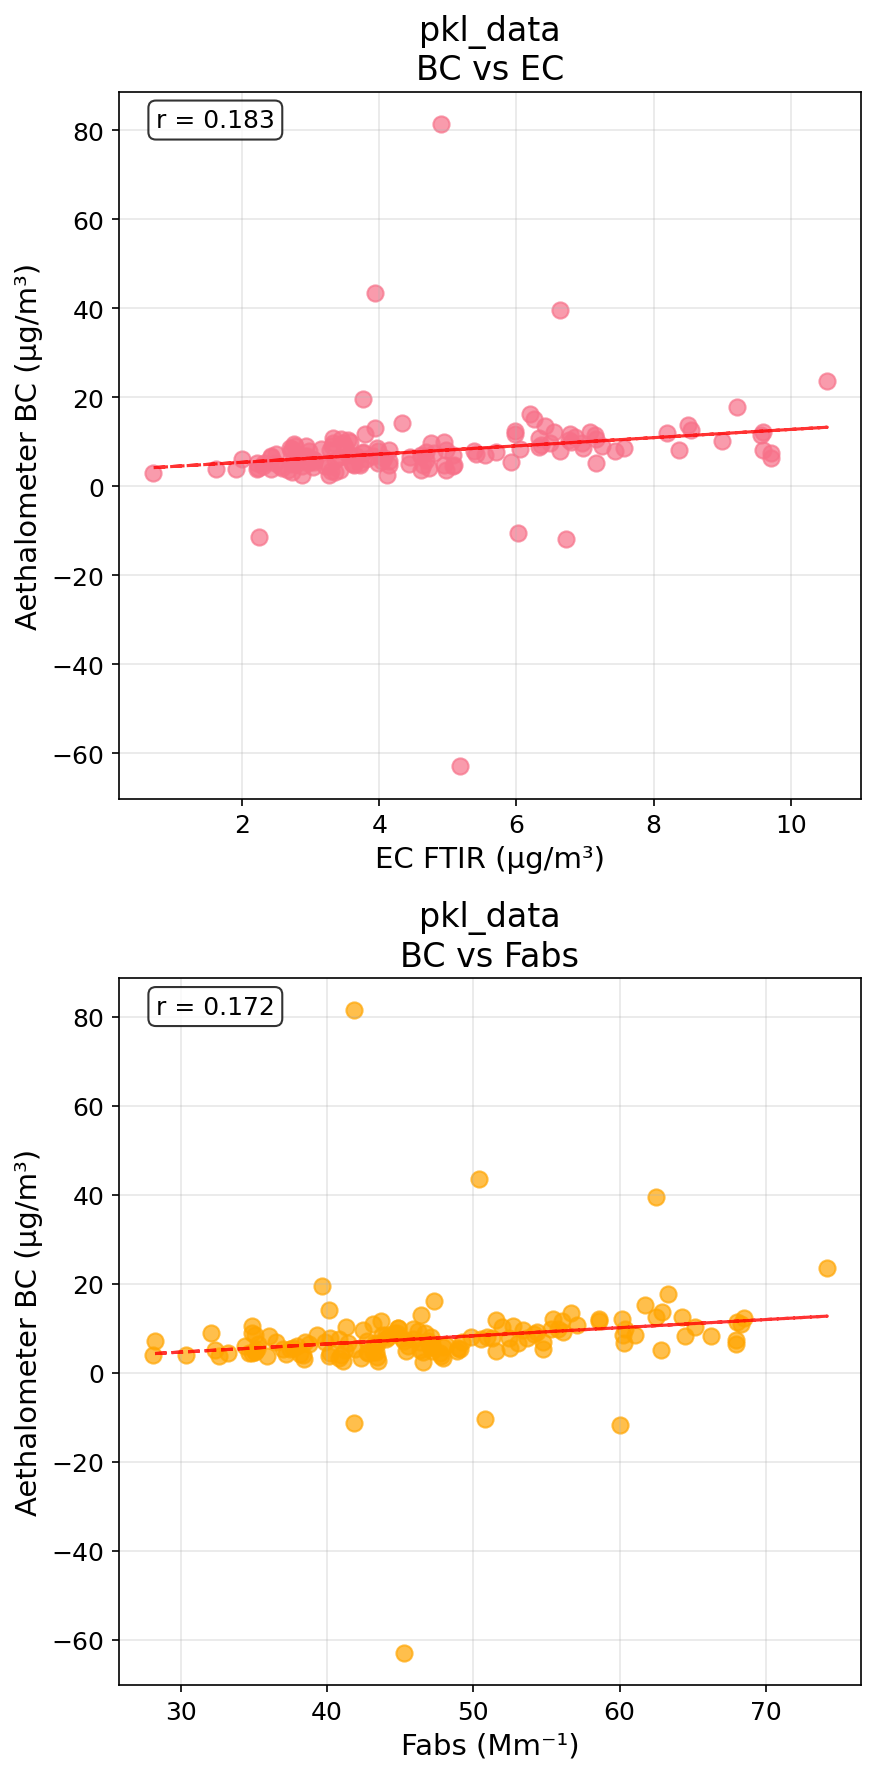


📈 Creating time series comparison...


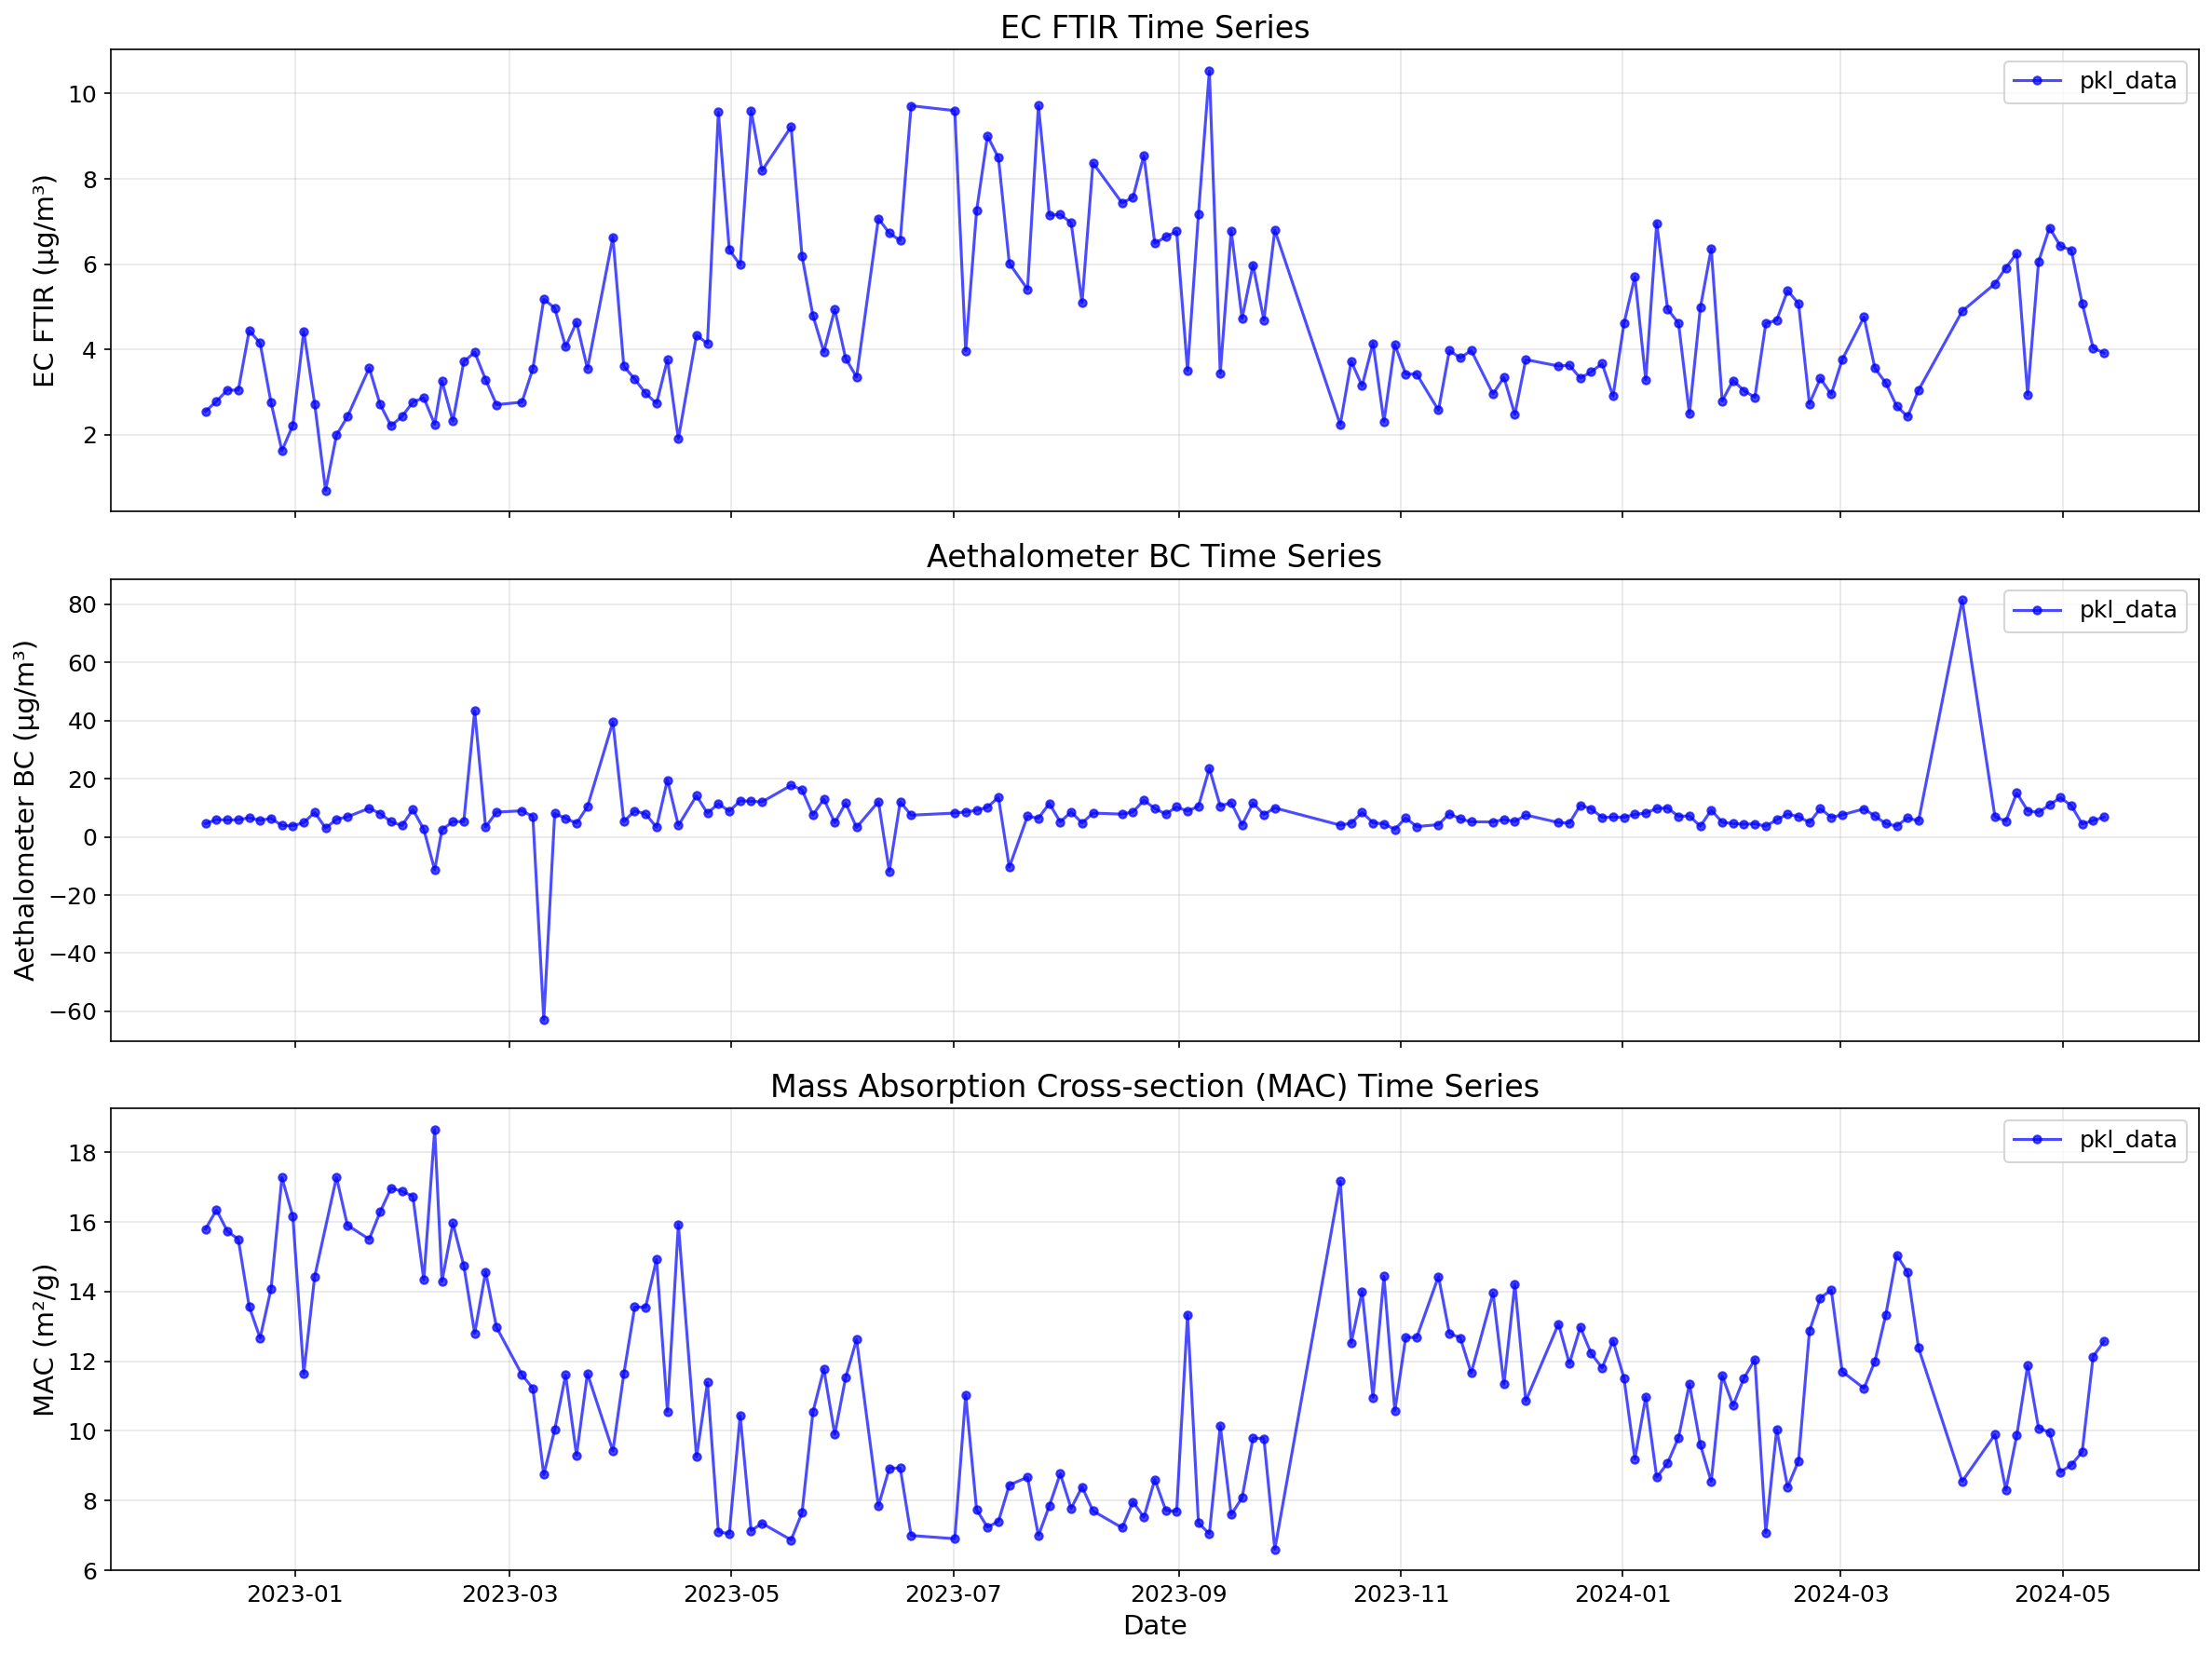


📈 Creating seasonal analysis...


TypeError: Axes.boxplot() got an unexpected keyword argument 'alpha'

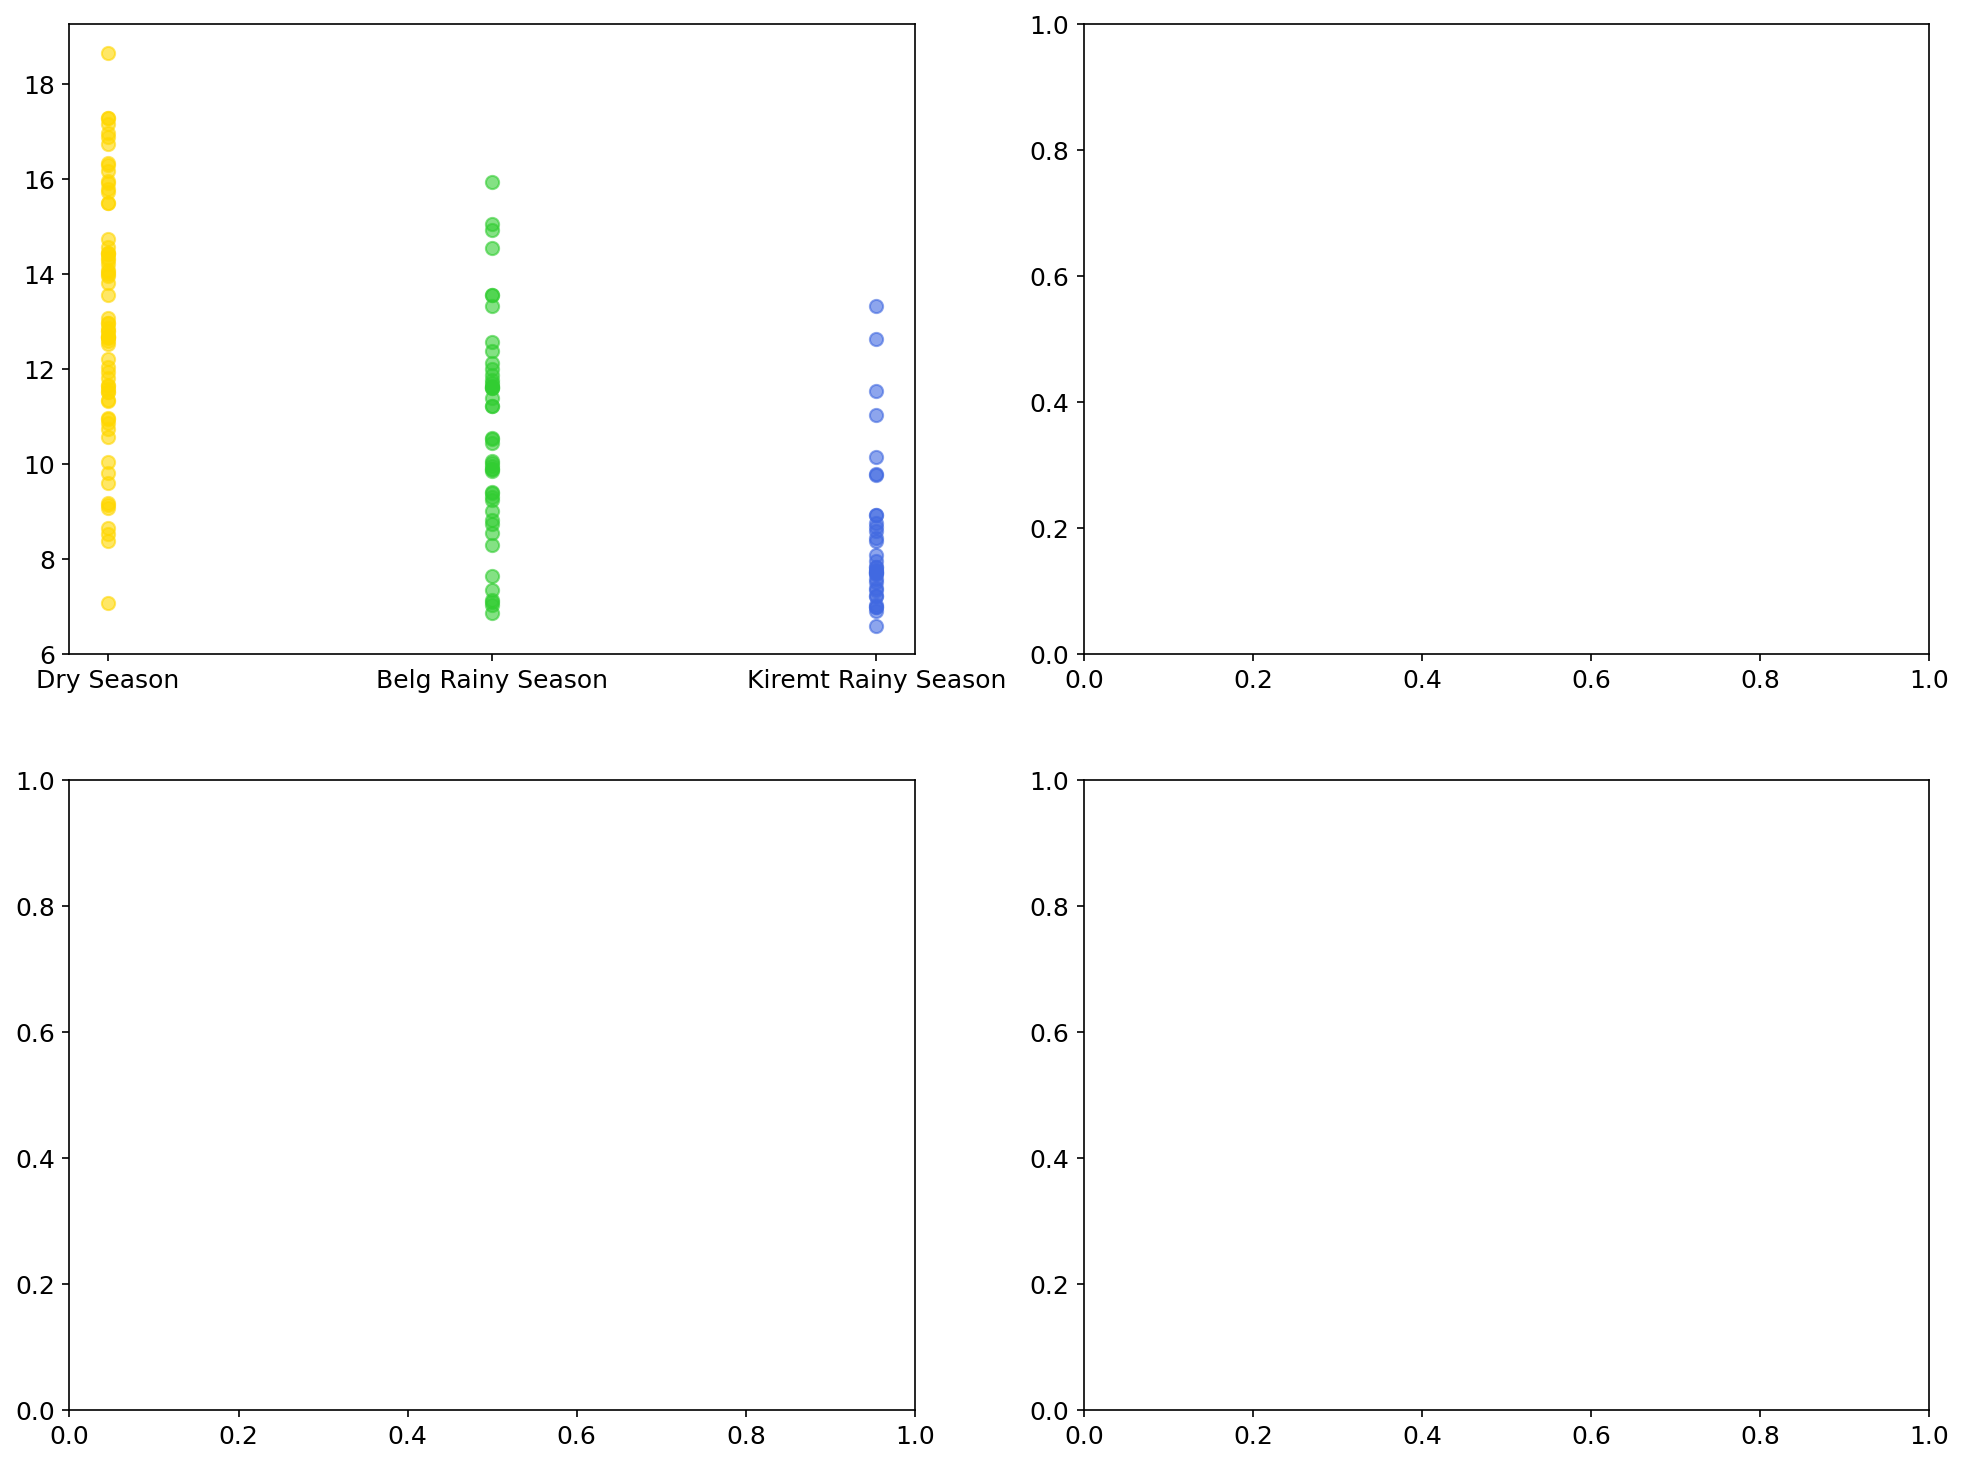

In [63]:
def plot_correlation_analysis(merged_datasets: Dict[str, pd.DataFrame]):
    """Create correlation plots for all datasets"""
    
    if not merged_datasets:
        print("No data available for plotting")
        return
    
    n_datasets = len(merged_datasets)
    fig, axes = plt.subplots(2, n_datasets, figsize=(6*n_datasets, 12))
    
    if n_datasets == 1:
        axes = axes.reshape(-1, 1)
    
    dataset_names = list(merged_datasets.keys())
    
    for idx, (dataset_name, merged_df) in enumerate(merged_datasets.items()):
        if len(merged_df) == 0:
            continue
        
        # Convert BC to µg/m³
        merged_df['aeth_bc_ug'] = merged_df['aeth_mean'] / 1000
        
        # Plot 1: BC vs EC
        ax1 = axes[0, idx]
        valid_data = merged_df[['aeth_bc_ug', 'EC_FTIR']].dropna()
        
        if len(valid_data) > 1:
            ax1.scatter(valid_data['EC_FTIR'], valid_data['aeth_bc_ug'], alpha=0.7, s=60)
            
            # Add trend line
            z = np.polyfit(valid_data['EC_FTIR'], valid_data['aeth_bc_ug'], 1)
            p = np.poly1d(z)
            ax1.plot(valid_data['EC_FTIR'], p(valid_data['EC_FTIR']), "r--", alpha=0.8)
            
            # Add correlation
            correlation = valid_data['aeth_bc_ug'].corr(valid_data['EC_FTIR'])
            ax1.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax1.transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax1.set_xlabel('EC FTIR (µg/m³)')
        ax1.set_ylabel('Aethalometer BC (µg/m³)')
        ax1.set_title(f'{dataset_name}\nBC vs EC')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: BC vs Fabs
        ax2 = axes[1, idx]
        valid_data_fabs = merged_df[['aeth_bc_ug', 'Fabs']].dropna()
        
        if len(valid_data_fabs) > 1:
            ax2.scatter(valid_data_fabs['Fabs'], valid_data_fabs['aeth_bc_ug'], 
                       alpha=0.7, s=60, color='orange')
            
            # Add trend line
            z = np.polyfit(valid_data_fabs['Fabs'], valid_data_fabs['aeth_bc_ug'], 1)
            p = np.poly1d(z)
            ax2.plot(valid_data_fabs['Fabs'], p(valid_data_fabs['Fabs']), "r--", alpha=0.8)
            
            # Add correlation
            correlation = valid_data_fabs['aeth_bc_ug'].corr(valid_data_fabs['Fabs'])
            ax2.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax2.transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax2.set_xlabel('Fabs (Mm⁻¹)')
        ax2.set_ylabel('Aethalometer BC (µg/m³)')
        ax2.set_title(f'{dataset_name}\nBC vs Fabs')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_time_series_comparison(merged_datasets: Dict[str, pd.DataFrame]):
    """Create time series comparison plots"""
    
    if not merged_datasets:
        print("No data available for time series plotting")
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for idx, (dataset_name, merged_df) in enumerate(merged_datasets.items()):
        if len(merged_df) == 0:
            continue
        
        color = colors[idx % len(colors)]
        merged_df_sorted = merged_df.sort_values('collection_date')
        merged_df_sorted['aeth_bc_ug'] = merged_df_sorted['aeth_mean'] / 1000
        
        # EC FTIR
        axes[0].plot(merged_df_sorted['collection_date'], merged_df_sorted['EC_FTIR'], 
                    'o-', label=f'{dataset_name}', color=color, alpha=0.7, markersize=4)
        
        # Aethalometer BC
        axes[1].plot(merged_df_sorted['collection_date'], merged_df_sorted['aeth_bc_ug'], 
                    'o-', label=f'{dataset_name}', color=color, alpha=0.7, markersize=4)
        
        # MAC
        if 'MAC' in merged_df_sorted.columns:
            # Filter extreme MAC values for better visualization
            mac_filtered = merged_df_sorted['MAC'][(merged_df_sorted['MAC'] > 0) & (merged_df_sorted['MAC'] < 30)]
            dates_filtered = merged_df_sorted['collection_date'][(merged_df_sorted['MAC'] > 0) & (merged_df_sorted['MAC'] < 30)]
            
            axes[2].plot(dates_filtered, mac_filtered, 
                        'o-', label=f'{dataset_name}', color=color, alpha=0.7, markersize=4)
    
    axes[0].set_ylabel('EC FTIR (µg/m³)')
    axes[0].set_title('EC FTIR Time Series')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_ylabel('Aethalometer BC (µg/m³)')
    axes[1].set_title('Aethalometer BC Time Series')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_ylabel('MAC (m²/g)')
    axes[2].set_title('Mass Absorption Cross-section (MAC) Time Series')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_seasonal_analysis(merged_datasets: Dict[str, pd.DataFrame]):
    """Create seasonal analysis plots"""
    
    # Combine all datasets for seasonal analysis
    all_data = []
    for dataset_name, merged_df in merged_datasets.items():
        if len(merged_df) > 0:
            df_copy = merged_df.copy()
            df_copy['dataset'] = dataset_name
            df_copy['aeth_bc_ug'] = df_copy['aeth_mean'] / 1000
            all_data.append(df_copy)
    
    if not all_data:
        print("No data available for seasonal analysis")
        return
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Create seasonal plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Season colors
    season_colors = {
        'Dry Season': 'gold',
        'Belg Rainy Season': 'limegreen', 
        'Kiremt Rainy Season': 'royalblue'
    }
    
    # Plot 1: MAC by season
    if 'MAC' in combined_df.columns and 'season' in combined_df.columns:
        mac_filtered = combined_df[(combined_df['MAC'] > 0) & (combined_df['MAC'] < 30)]
        
        for season in mac_filtered['season'].unique():
            season_data = mac_filtered[mac_filtered['season'] == season]
            axes[0, 0].scatter(season_data['season'], season_data['MAC'], 
                             color=season_colors.get(season, 'gray'), 
                             alpha=0.6, s=40, label=f'{season} (n={len(season_data)})')
        
        # Add box plot overlay
        seasons = mac_filtered['season'].unique()
        mac_by_season = [mac_filtered[mac_filtered['season'] == season]['MAC'] for season in seasons]
        axes[0, 0].boxplot(mac_by_season, positions=range(len(seasons)), 
                          labels=seasons, alpha=0.3)
        
        axes[0, 0].set_ylabel('MAC (m²/g)')
        axes[0, 0].set_title('MAC by Ethiopian Season')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: BC vs EC by season
    valid_data = combined_df[['aeth_bc_ug', 'EC_FTIR', 'season']].dropna()
    
    for season in valid_data['season'].unique():
        season_data = valid_data[valid_data['season'] == season]
        axes[0, 1].scatter(season_data['EC_FTIR'], season_data['aeth_bc_ug'],
                          color=season_colors.get(season, 'gray'),
                          alpha=0.6, s=40, label=f'{season} (n={len(season_data)})')
    
    axes[0, 1].set_xlabel('EC FTIR (µg/m³)')
    axes[0, 1].set_ylabel('Aethalometer BC (µg/m³)')
    axes[0, 1].set_title('BC vs EC by Season')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Monthly trends
    if 'month' in combined_df.columns:
        monthly_stats = combined_df.groupby('month').agg({
            'aeth_bc_ug': ['mean', 'count'],
            'EC_FTIR': 'mean',
            'MAC': 'mean'
        }).round(2)
        
        months = monthly_stats.index
        axes[1, 0].plot(months, monthly_stats['aeth_bc_ug']['mean'], 'bo-', label='BC')
        axes[1, 0].plot(months, monthly_stats['EC_FTIR']['mean'], 'ro-', label='EC')
        
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].set_ylabel('Concentration (µg/m³)')
        axes[1, 0].set_title('Monthly BC and EC Trends')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_xticks(range(1, 13))
    
    # Plot 4: Data availability by season
    if 'season' in combined_df.columns:
        season_counts = combined_df['season'].value_counts()
        colors_list = [season_colors.get(season, 'gray') for season in season_counts.index]
        
        axes[1, 1].bar(season_counts.index, season_counts.values, color=colors_list, alpha=0.7)
        axes[1, 1].set_ylabel('Number of Samples')
        axes[1, 1].set_title('Data Availability by Season')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create all visualizations
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

if merged_datasets:
    print("\n📈 Creating correlation analysis plots...")
    fig_corr = plot_correlation_analysis(merged_datasets)
    
    print("\n📈 Creating time series comparison...")
    fig_ts = plot_time_series_comparison(merged_datasets)
    
    print("\n📈 Creating seasonal analysis...")
    fig_seasonal = plot_seasonal_analysis(merged_datasets)
else:
    print("⚠️ No merged datasets available for visualization")

## 9. Export Results

In [ ]:
def export_results(merged_datasets: Dict[str, pd.DataFrame], 
                  analysis_results: Dict,
                  output_dir: str):
    """Export all results to files"""
    
    print(f"\n📤 Exporting results to: {output_dir}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Export individual merged datasets
    for dataset_name, merged_df in merged_datasets.items():
        csv_path = os.path.join(output_dir, f'merged_{dataset_name}.csv')
        merged_df.to_csv(csv_path, index=False)
        print(f"✅ Exported {dataset_name}: {csv_path}")
    
    # Export combined dataset if multiple
    if len(merged_datasets) > 1:
        combined_df = pd.concat(merged_datasets.values(), ignore_index=True)
        combined_path = os.path.join(output_dir, 'merged_combined_all_datasets.csv')
        combined_df.to_csv(combined_path, index=False)
        print(f"✅ Exported combined dataset: {combined_path}")
    
    # Export analysis results as JSON
    import json
    
    # Convert numpy types to Python types for JSON serialization
    def convert_for_json(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.Timestamp):
            return obj.isoformat()
        elif hasattr(obj, 'date'):
            return obj.isoformat()
        return obj
    
    json_results = {}
    for dataset_name, stats in analysis_results.items():
        json_results[dataset_name] = {}
        for key, value in stats.items():
            if isinstance(value, dict):
                json_results[dataset_name][key] = {k: convert_for_json(v) for k, v in value.items()}
            else:
                json_results[dataset_name][key] = convert_for_json(value)
    
    json_path = os.path.join(output_dir, 'analysis_results.json')
    with open(json_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    print(f"✅ Exported analysis results: {json_path}")
    
    # Create summary report
    summary_path = os.path.join(output_dir, 'pipeline_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("AETHALOMETER-FTIR/HIPS PIPELINE SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Site: {SITE_CODE}\n")
        f.write(f"Wavelength: {WAVELENGTH}\n")
        f.write(f"Quality Threshold: {QUALITY_THRESHOLD} minutes\n\n")
        
        f.write("DATASETS PROCESSED:\n")
        f.write("-" * 20 + "\n")
        for dataset_name, merged_df in merged_datasets.items():
            f.write(f"{dataset_name}: {len(merged_df)} merged periods\n")
        
        f.write(f"\nFTIR/HIPS DATA:\n")
        f.write("-" * 20 + "\n")
        if ftir_data is not None:
            f.write(f"Total filter samples: {len(ftir_data)}\n")
            f.write(f"Date range: {ftir_data['sample_date'].min()} to {ftir_data['sample_date'].max()}\n")
        
        f.write(f"\nKEY CORRELATIONS:\n")
        f.write("-" * 20 + "\n")
        for dataset_name, stats in analysis_results.items():
            if 'correlations' in stats:
                f.write(f"{dataset_name}:\n")
                for corr_name, corr_value in stats['correlations'].items():
                    f.write(f"  {corr_name}: {corr_value:.3f}\n")
                f.write("\n")
    
    print(f"✅ Exported summary report: {summary_path}")
    print(f"\n🎯 Export completed! All results saved to: {output_dir}")

# Export all results
export_results(merged_datasets, analysis_results, OUTPUT_DIR)

## 10. Pipeline Summary

In [ ]:
def create_pipeline_summary():
    """Create a comprehensive summary of the pipeline results"""
    
    print("\n" + "="*80)
    print("🎯 PIPELINE SUMMARY")
    print("="*80)
    
    print(f"📊 Configuration:")
    print(f"   Site: {SITE_CODE}")
    print(f"   Wavelength: {WAVELENGTH}")
    print(f"   Quality threshold: {QUALITY_THRESHOLD} minutes")
    print(f"   Output directory: {OUTPUT_DIR}")
    
    print(f"\n📁 Data Loading:")
    print(f"   Aethalometer files processed: {len(aethalometer_datasets)}")
    for name, summary in aethalometer_summaries.items():
        print(f"     {name}: {summary['shape'][0]:,} rows ({summary['file_type']})")
    
    if ftir_data is not None:
        print(f"   FTIR/HIPS samples: {len(ftir_data)}")
        print(f"   FTIR date range: {ftir_data['sample_date'].min()} to {ftir_data['sample_date'].max()}")
    
    print(f"\n🔍 Quality Assessment:")
    for dataset_name, excellent_periods in excellent_periods_dict.items():
        print(f"   {dataset_name}: {len(excellent_periods)} excellent periods")
    
    print(f"\n🔗 Merging Results:")
    total_merged = sum(len(df) for df in merged_datasets.values())
    print(f"   Total merged periods: {total_merged}")
    for name, merged_df in merged_datasets.items():
        print(f"     {name}: {len(merged_df)} periods")
    
    print(f"\n📈 Key Findings:")
    for dataset_name, stats in analysis_results.items():
        if 'correlations' in stats and stats['correlations']:
            print(f"   {dataset_name}:")
            for corr_name, corr_value in stats['correlations'].items():
                print(f"     {corr_name}: {corr_value:.3f}")
            
            if 'mac_statistics' in stats:
                mac_mean = stats['mac_statistics']['mean']
                print(f"     Mean MAC: {mac_mean:.2f} m²/g")
    
    print(f"\n✅ Pipeline Status: COMPLETED SUCCESSFULLY")
    print(f"📤 Results exported to: {OUTPUT_DIR}")
    
    if merged_datasets:
        print(f"\n💡 Next Steps:")
        print(f"   • Review correlation plots for method comparison")
        print(f"   • Examine seasonal patterns in the data")
        print(f"   • Consider extending analysis to other wavelengths")
        print(f"   • Investigate periods with high/low correlations")
    
    print("="*80)

# Create final summary
create_pipeline_summary()

In [ ]:
# Final cell - display key results for quick reference
if merged_datasets:
    print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
    print("\n📊 Quick Results Summary:")
    
    for dataset_name, merged_df in merged_datasets.items():
        print(f"\n{dataset_name}:")
        print(f"  • Merged periods: {len(merged_df)}")
        
        if len(merged_df) > 0:
            # Quick correlation
            merged_df['aeth_bc_ug'] = merged_df['aeth_mean'] / 1000
            
            if 'EC_FTIR' in merged_df.columns:
                bc_ec_corr = merged_df['aeth_bc_ug'].corr(merged_df['EC_FTIR'])
                print(f"  • BC-EC correlation: {bc_ec_corr:.3f}")
            
            if 'MAC' in merged_df.columns:
                mac_mean = merged_df['MAC'][(merged_df['MAC'] > 0) & (merged_df['MAC'] < 30)].mean()
                print(f"  • Mean MAC: {mac_mean:.2f} m²/g")
    
    print(f"\n📁 All results saved to: {OUTPUT_DIR}")
else:
    print("⚠️ No successful merging occurred. Check configuration and data availability.")